# Importing the libraries and the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import pickle
import os
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from numpy import random
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from smoteboost import SMOTEBoost
from rusboost import RUSBoost
from datetime import datetime

print('Libraries imported successfully!')

Libraries imported successfully!


# Modelling
We are going to use the following machine learning models:
1. Logistic Regression
2. KNN Classifier
3. Decision Trees
4. Random Forests
5. XGBoost
6. SMOTEBoost
7. RUSBoost
___

For modelling, we are going to use all the datasets constructed in the notebook _IDA 2016_01- EDA and Feature Engineering.ipynb_, i.e. the imputed datasets without any features, datasets containing the engineered features and the adding the Encodings generated by the autoencoder to the corresponding datasets. We will use both the KNN and MICE imputations and see which of them performs better. Also, since there are so many models we are going to experiment with, on the stock imputed datasets without any feature engineering, we are going to train all the models, however, for the other datasets, we are going to use the top 3 performing models only to decrease the amount of models we train.

Since the dataset has a very high imbalance, we are going to tune the prediction thresholds of the models for the best performing models we get. For tuning and finding the optimal threshold, we are going to check the variation in the f1 score and the misclassification cost upon changning the value of the prediction threshold. 
Also, we are going to use the custom ensembles SMOTEBoost and RUSBoost later and check their performance.

## Defining the custom metric
We also need to define the custom cost metric that will be the final metric for comparing performance between models.

In [2]:
def misclassification_score(y_true, y_pred):
    '''
        This function is used to calculate the cost metric for each model.
    '''
    # calculating confusion metrics
    conf_ = confusion_matrix(y_true, y_pred)
    fp = conf_[0,1]
    fn = conf_[1,0]
    return (10*fp) + (500*fn)

In [3]:
def plot_matrices(y_true, y_pred):
    '''
        This function is going to plot the confusion, precision and recall metrics for the model predictions.
    '''
    # confusion matrix
    confusion = confusion_matrix(y_true, y_pred)
    # precision matrix - column sum of confusion matrix
    precision = confusion/confusion.sum(axis=0)
    # recall matrix - row sum of confusion matrix
    recall = (confusion.T/confusion.sum(axis=1)).T
    
    # plot these matrices
    fig, ax = plt.subplots(ncols=3, figsize=(15,6))
    sns.heatmap(confusion, cbar=False, annot=True, ax=ax[0], fmt='g', cmap='YlGnBu')
    sns.heatmap(precision, cbar=False, annot=True, ax=ax[1], fmt='g', cmap='YlGnBu')
    sns.heatmap(recall, cbar=False, annot=True, ax=ax[2], fmt='g', cmap='YlGnBu')
    
    ax[0].set_title('Confusion matrix')
    ax[1].set_title('Precision matrix')
    ax[2].set_title('Recall matrix')
    
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")
    ax[2].set_xlabel("Predicted")
    ax[2].set_ylabel("Actual")
    plt.show()

However, before modelling, it is necessary that we find out what is the worst performance any model can achieve in this dataset. If a model is performing worse than the _dumb_ model we are going to make, we will declare the model to be completely useless and ignore it. Every trained model that we are going to use in this case study should perform better than the baseline model.

## 1. Baseline Model

Our baseline model will generate random class labels for each datapoint. However, instead of just randomly labeling each datapoint, the model is going to have a bias towards the negative class datapoint in order to take into account the imbalance in the dataset. 
For getting a biased model our approach will be as follows:
> 1. Set a threshold, say T.
2. Select a number between 0 and 1 randomly from a uniform random variable.
3. If the selected number is greater than T, return positive class
4. Else, return negative class.

I have decided to arbitrarily set this threshold to 0.95 such that for every prediction the model makes, there will be 95% chance of a negative and only 5% chance of a positive prediction.

In [4]:
def baseline_model():
    '''
        This is the baseline model for this problem statement.
    '''
    y_pred = np.zeros(16000)
    # threshold
    tau = 0.98
    
    for i in range(16000):
        # select a random number between 0 and 1
        sel = random.uniform()
        # check for prediction
        if sel >= tau:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred

In [5]:
# loading the dataset
data_train = pd.read_csv("Data\\train.csv", na_values='na')
data_test = pd.read_csv("Data\\testset.csv", na_values='na')

In [6]:
# tokenizing the class labels for the test set
Y_test = np.array([1 if i=='pos' else 0 for i in data_test['class'].values])

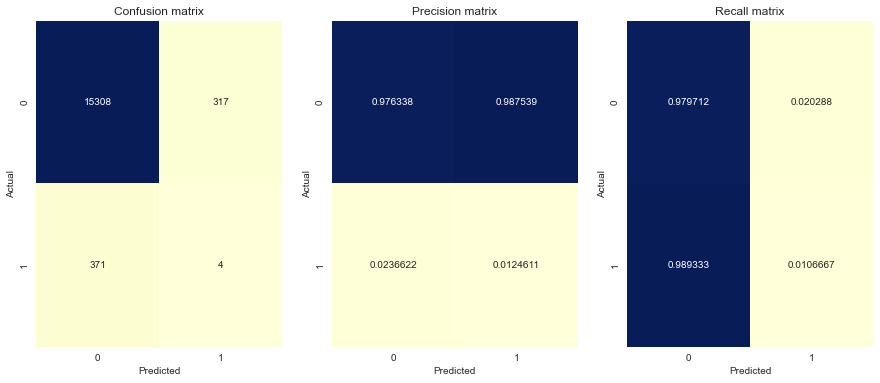

F-1 Score: 0.49475811544777065
Misclassification cost: 188670


In [133]:
# making predictions using baseline model
y_pred = baseline_model()
# plot the matrices
plot_matrices(Y_test, y_pred)
# calculating the f1 score and cost
f1 = f1_score(Y_test, y_pred, average='macro')
cost = misclassification_score(Y_test, y_pred)
print("F-1 Score:", f1)
print("Misclassification cost:", cost)

As we can see, the baseline model performs very badly in the positive (minority) class. It has a f1 score of 0.033 and a misclassification cost of 185,720. Any model we train now should have metrics better than these. This model has a very large bias towards the negative class given the imbalanced nature of the dataset as seen from the confusion, precision and recall matrices.

## 2. Modelling for KNN Imputed datasets
First we will use the dataset without custom features for training all the models. We are going to train models both on the mice and knn imputed datasets and then compare both of them to choose the best imputation metric and the best models among them. For hyperparameter tuning, we are going to use GridSearchCV and the metric used will be the macro-averaged F-1 Score.

### Loading the train and test dataset (without any features)

In [7]:
knn_train = pd.read_csv("Saves\\Datasets\\stock-knn-norm-train.csv")
knn_test = pd.read_csv("Saves\\Datasets\\stock-knn-norm-test.csv")

print(knn_train.shape, knn_test.shape)
knn_train.head()

(60000, 163) (16000, 163)


,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.027925,9.999998e-01,3.261769e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000163,...,0.015918,0.013067,7.421784e-03,8.179508e-03,1.073013e-02,0.001321,0.003800,0.000000,0.000000,0.000000
1,0.012036,0.000000e+00,2.427688e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000080,...,0.005407,0.004716,3.019031e-03,4.272917e-03,4.228511e-03,0.000679,0.005064,0.000394,0.000000,0.000000
2,0.014942,1.070067e-07,1.164918e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000007,...,0.003559,0.004232,4.364196e-03,7.130884e-03,1.014768e-02,0.001321,0.004937,0.000135,0.000000,0.000000
3,0.000004,3.285295e-08,7.688457e-09,0.0,0.000498,0.0,0.0,0.0,0.000005,0.000010,...,0.000003,0.000001,5.970003e-07,7.660803e-07,3.163775e-07,0.000000,0.000000,0.000000,0.008299,0.027923
4,0.022164,6.420405e-07,5.335323e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000191,...,0.007981,0.006086,4.171776e-03,6.044861e-03,9.078578e-03,0.002605,0.022523,0.000320,0.000000,0.000000


In [8]:
# check for class distribution in the test dataset
print(data_test['class'].value_counts())

neg    15625
pos      375
Name: class, dtype: int64


In [9]:
# getting the class labels
Y = data_train['class']
Y_test = data_test['class']

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)
Y_test = le.transform(Y_test)

### Some utility functions
#### 1. Hyperparameter tuning

In [11]:
def tuner(data, labels, model, parameters, metrics='f1_macro'):
    '''
        This function does hyperparameter tuning for a specific model given a dictionary containing all the hyperparameters.
        The scoring here used will be the f1 score.
    '''
    start = datetime.now()
    # declaring the gridsearch object
    gridsearch = GridSearchCV(estimator=model,
                             param_grid=parameters,
                             scoring='f1_macro',
                             n_jobs=-1,
                             verbose=100,
                             cv=3,
                             return_train_score=True)
    # fitting the data
    gridsearch.fit(data, labels)
    print("Best Parameters:", gridsearch.best_params_)
    print("F1 score:", gridsearch.best_score_)
    print("Time taken:", datetime.now()-start)
    
    return gridsearch

#### 2. Plot performance curve

In [12]:
def performance_curve(gridsearch, params):
    '''
        This function plots the performance curve for a model with different hyperparameters given its gridsearch object.
    '''
    # get the results
    performance = gridsearch.cv_results_
    
    # plot
    train_perf = performance['mean_train_score']
    val_perf = performance['mean_test_score']
    
    p = sns.lineplot(x=params, y=train_perf, label='Train')
    sns.lineplot(x=params, y=val_perf, label='Validation')
    sns.scatterplot(x=params, y=train_perf, label='Train')
    sns.scatterplot(x=params, y=val_perf, label='Validation')
    
    # adding f1 scores to the plot - https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
    for i in range(len(params)):
        p.text(params[i], val_perf[i], "T:"+str(round(train_perf[i], 4))+"\nV:"+str(round(val_perf[i], 4)))
    
    plt.xlabel("Parameter")
    plt.ylabel("F-1 Score")
    plt.title("Performance Plot.")
    plt.legend()
    plt.show()

#### 3. For saving the model

In [13]:
def save_model(model, name):
    '''
        This function saves the models to the disk.
    '''
    savepath = 'Saves\\ML\\'+name+'.pickle'
    with open(savepath, 'wb') as f:
        pickle.dump(model, f)
    print("Saved model at:", savepath)

#### 4. Evaluating model performance on the test data

In [14]:
def evaluate_performance(model, train_data, y_train, test_data, y_test):
    '''
        This function prints the models performance metrics after making predictions.
    '''
    print("Making predictions...")
    pred_train = model.predict(train_data)
    pred_test = model.predict(test_data)
    
    print('---PERFORMANCE REPORT---')
    print('Confusion, Precision and Recall Matrices...')
    plot_matrices(y_test, pred_test)
    print('-'*100)
    
    print('Train F-1 Score:', f1_score(y_train, pred_train, average='macro'))
    print('Test F-1 Score:', f1_score(y_test, pred_test, average='macro'))
    print('-'*100)
    print("Train Misclassification cost:", misclassification_score(y_train, pred_train))
    print("Test Misclassification cost:", misclassification_score(y_test, pred_test))

### 1. Logistic Regression

In [16]:
# performing hyperparameter tuning
lr = SGDClassifier(loss='log')
params = {'alpha':[10**i for i in range(-7, 3)]}
lr_gridsearch = tuner(knn_train, Y, lr, params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'alpha': 1e-06}
F1 score: 0.8494797111743954
Time taken: 0:00:06.421988


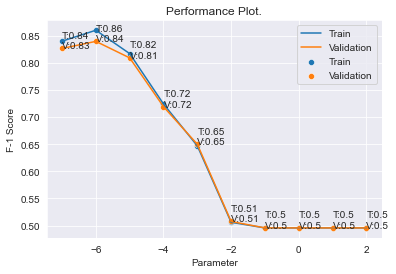

In [123]:
# plotting the perforamnce plot
performance_curve(lr_gridsearch, [i for i in range(-7,3)])

From the plot, alpha=1e-6 seems to be the best value. Refitting the model with the best alpha and showing the results.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


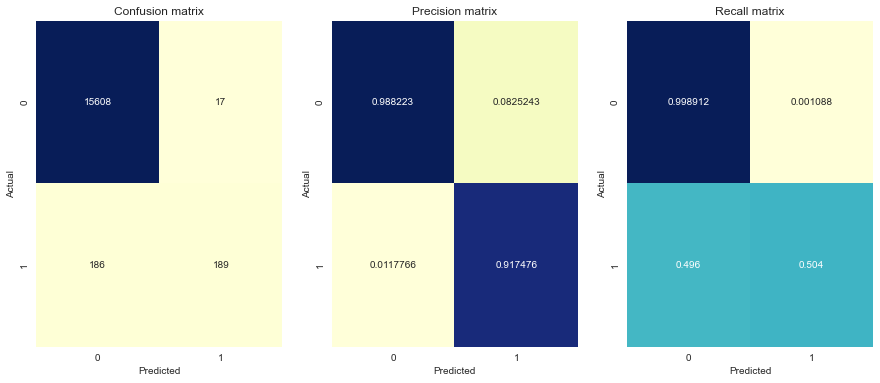

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.8162158699136113
Test F-1 Score: 0.8220706755217183
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 255960
Test Misclassification cost: 93170


In [25]:
lr = SGDClassifier(loss='log', alpha=1e-6)
lr.fit(knn_train, Y) # fitting

evaluate_performance(lr, knn_train, Y, knn_test, Y_test)

Logistic Regression works very well in the positive class as expected. It has a higher f1 score and lower misclassification cost compared to the baseline model. However, it still has problems in predicting positive class datapoints as seen in the confusion matrix. The precision too, is quite high for the positive class, i.e. 0.86 which means it is mostly right in its predictions it makes for the positive class. However, as we can see from the low recall score and confusion matrix, it is not making a lot of classifications for the positive class which is a result of the high imbalance and the model's inherit bias of linear separability of the classes.

__NOTE:__ Misclassifiation cost is calculated using the fp and fn datapoints. Now since the number of datapoints is more in train data then the test data the cost for train data is going to be larger than that for the test data. Also, the baseline model's cost is calculated using the test data.

### 2. KNN Classifier.

In [134]:
# performing hyperparamter tuning 
knn = KNeighborsClassifier()
params = {'n_neighbors':[5,25,55,105,155]}
knn_gridsearch = tuner(knn_train, Y, knn, params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Anaconda\envs\MachineLearning\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_neighbors': 5}
F1 score: 0.7718981582825597
Time taken: 0:12:52.750496


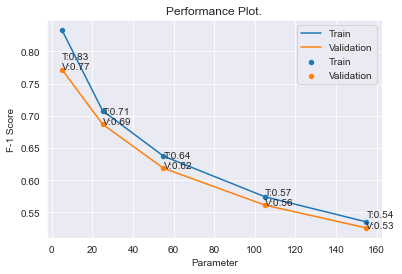

In [135]:
# plotting the performance plot
performance_curve(knn_gridsearch, params['n_neighbors'])

_25 Neighbors_ seem to be the best value as for 5 even though we have a higher value of f-1 score but the difference between the train and the validation set metrics is very large and the model overfits.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


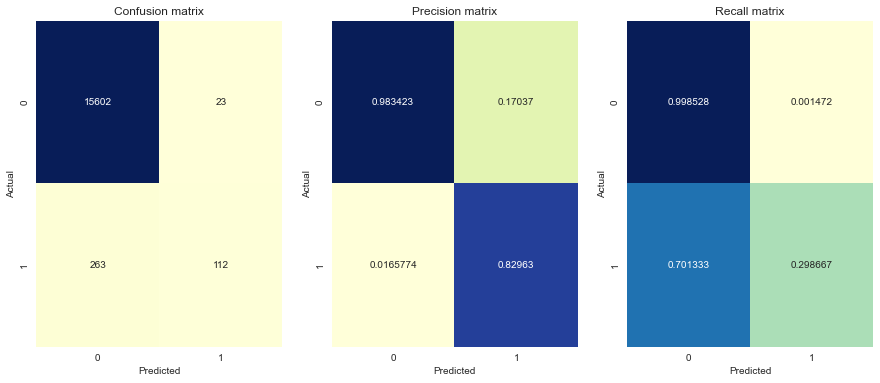

----------------------------------------------------------------------------------------------------
F-1 Score: 0.7150667189708528
----------------------------------------------------------------------------------------------------
Misclassification cost: 131730


In [136]:
# fitting the best model and evaluating the performance
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
knn.fit(knn_train, Y)
evaluate_performance(knn, knn_train, Y, knn_test, Y_test)

KNN has worse performance compared to Logistic Regression as seen from the f1 score and misclassification costs but it still performs better than the baseline model. However, bias towards the negative is still there and is much more. A reason for this might be that a lot of positive class datapoints are surrounded by negative class datapoints as we saw in the t- plot during the EDA. This would make a neighbour based model such as KNN perform badly which we can see here as well.

### 3. Decision Trees

In [137]:
# performing hyperparameter tuning
dt = DecisionTreeClassifier(random_state=0)
params = {'max_depth':[3, 5, 15, 50, 150, 300]}
dt_gridsearch = tuner(knn_train, Y, dt, params)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 15}
F1 score: 0.839918953802537
Time taken: 0:00:35.890968


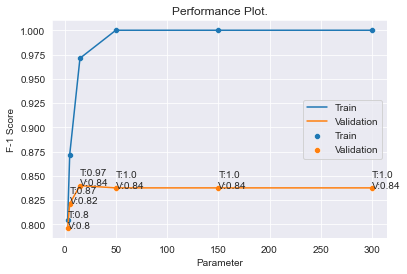

In [138]:
# plotting the performance plot
performance_curve(dt_gridsearch, params['max_depth'])

As we can see, the decision tree overfits very quickly in only depth=15. The best performance is achieved at 5 splits.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


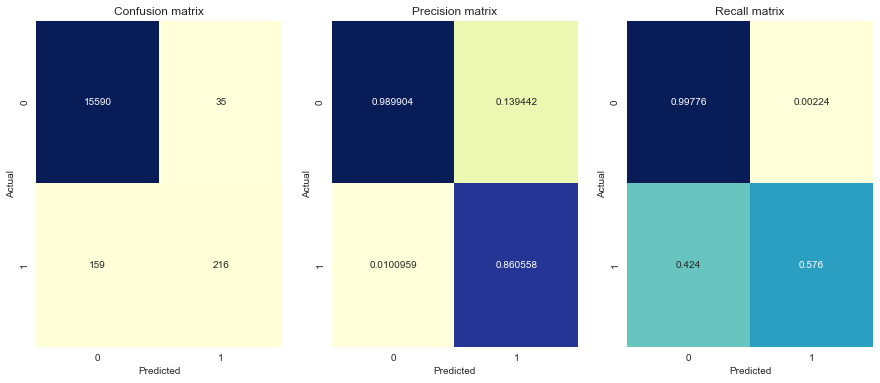

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.8733759317075356
Test F-1 Score: 0.8419561913152891
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 173890
Test Misclassification cost: 79850


In [27]:
# training the best model
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(knn_train, Y)
# evaluating the model
evaluate_performance(dt, knn_train, Y, knn_test, Y_test)

Decision tree performs better than all the models till now. It has an f1 score of 0.84 (approx) and the lowest micalssification cost of 79,830. As we can see, the recall too is higher at 0.58 compared to the other models.

### 4. Random Forest 

__Note:__ The tree based ensembles tend to overfit very quickly, thus, it is advisable to use shallower depths for both XGBoost and Random Forests.

In [132]:
# hyperparameter tuning
rf = RandomForestClassifier(n_jobs=-1, max_depth=7)
params = {'n_estimators':[3, 5, 10, 50, 100, 200]}
rf_gridsearch = tuner(knn_train, Y, rf, params)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'n_estimators': 100}
F1 score: 0.8521012803762446
Time taken: 0:00:22.135371


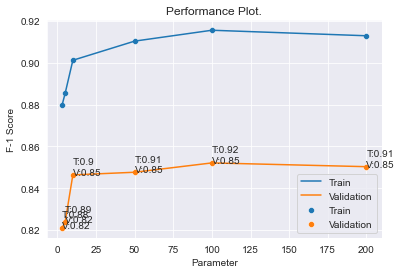

In [133]:
# plot the performance plot
performance_curve(rf_gridsearch, params['n_estimators'])

From the performance plot, we can see that n_trees=100 seems to be the best value.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


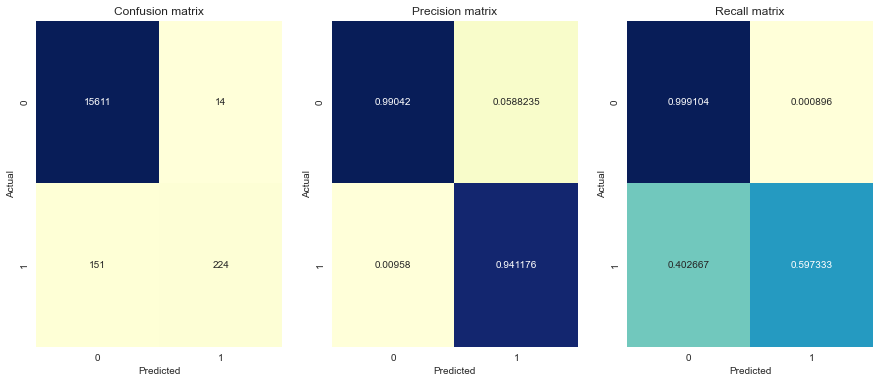

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9078650631072882
Test F-1 Score: 0.8627875101915357
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 152050
Test Misclassification cost: 75640


In [26]:
# refitting the model with the best models
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=7)
rf.fit(knn_train, Y)
# evaluating the performance
evaluate_performance(rf, knn_train, Y, knn_test, Y_test)

Random forest model has a test f1 score of 0.85 and a misclassification cost of 77,640.

### 5. XGBoost

In [149]:
# hyperparameter tuning
xgbc = XGBClassifier(n_jobs=-1, max_depth=2)
params = {'n_estimators':[3,5,15,50,100,300]} # number of base learners
xgb_gridsearch = tuner(knn_train, Y, xgbc, params)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'n_estimators': 300}
F1 score: 0.8998404255382245
Time taken: 0:00:54.381835


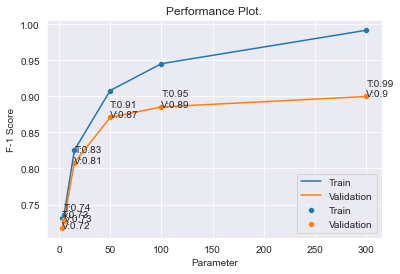

In [150]:
# performance plot
performance_curve(xgb_gridsearch, params['n_estimators'])

From the dataframe, we can see that the best value of hyperparameter is 50. For higher values, the model starts to overfit.

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


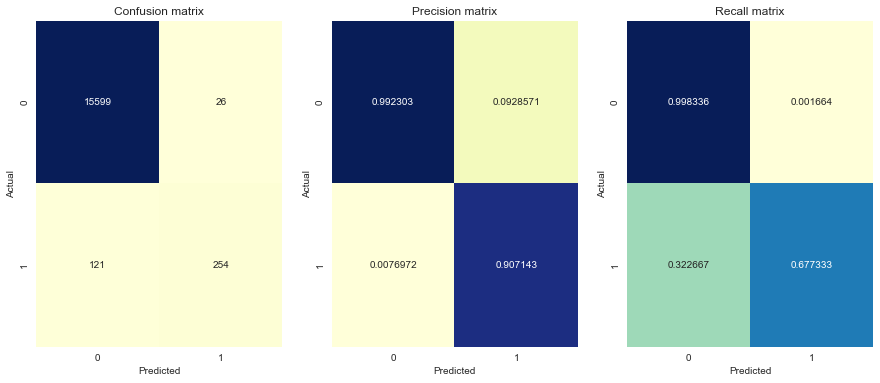

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.901954702501327
Test F-1 Score: 0.8854413879516194
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 136280
Test Misclassification cost: 60760


In [28]:
# training the best model
xgbc = XGBClassifier(n_estimators=50, n_jobs=-1, max_depth=2)
xgbc.fit(knn_train, Y)

# performance evaluation
evaluate_performance(xgbc, knn_train, Y, knn_test, Y_test)

The XGBoost model performs better than the random forest model with an f1 score of 0.88 and a misclassification cost of 60670.

## The performance of various models in for the KNN imputed dataset summarized:

In [29]:
from prettytable import PrettyTable

x = PrettyTable(field_names=['Model', 'Test F1-score', 'Test Misclassification Cost', 'Positive class Recall', "FN", 'FP'])
x.add_row(['Baseline Model', '0.49', '188670', '0.01', '371', '317'])
x.add_row(['Logistic Regression', '0.82', '93170', '0.504', '186', '17'])
x.add_row(['KNN', '0.71', '131730', '0.30', '263', '23'])
x.add_row(['Decision Trees', '0.84', '79850', '0.57', '159', '35'])
x.add_row(['Random Forests', '0.86', '75640', '0.59', '151', '14'])
x.add_row(['XGBoost', '0.88', '60760', '0.67', '121', '26'])


print(x)

+---------------------+---------------+-----------------------------+-----------------------+-----+-----+
|        Model        | Test F1-score | Test Misclassification Cost | Positive class Recall |  FN |  FP |
+---------------------+---------------+-----------------------------+-----------------------+-----+-----+
|    Baseline Model   |      0.49     |            188670           |          0.01         | 371 | 317 |
| Logistic Regression |      0.82     |            93170            |         0.504         | 186 |  17 |
|         KNN         |      0.71     |            131730           |          0.30         | 263 |  23 |
|    Decision Trees   |      0.84     |            79850            |          0.57         | 159 |  35 |
|    Random Forests   |      0.86     |            75640            |          0.59         | 151 |  14 |
|       XGBoost       |      0.88     |            60760            |          0.67         | 121 |  26 |
+---------------------+---------------+-------

## 3. Modelling for MICE Imputed dataset

In [15]:
# loading the mice imputed dataset without any features
mice_train = pd.read_csv('Saves//Datasets/stock-mice-norm-train.csv')
mice_test = pd.read_csv('Saves//Datasets/stock-mice-norm-test.csv')

print(mice_train.shape, mice_test.shape)

(60000, 163) (16000, 163)


### 1. Logistic Regression

In [159]:
# hyperparameter tuning
lr = SGDClassifier(loss='log')
params = {'alpha':[10**i for i in range(-7,3)]}
lr_gridsearch = tuner(mice_train, Y, lr, params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'alpha': 1e-06}
F1 score: 0.827693681554435
Time taken: 0:00:05.519328


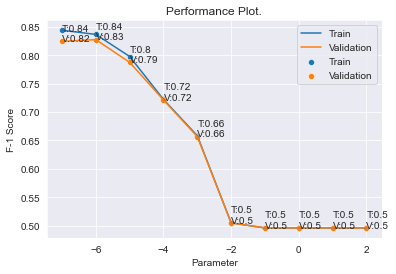

In [160]:
# performance plot
performance_curve(lr_gridsearch, [i for i in range(-7,3)])

The best value of alpha seems to be 1e-6.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


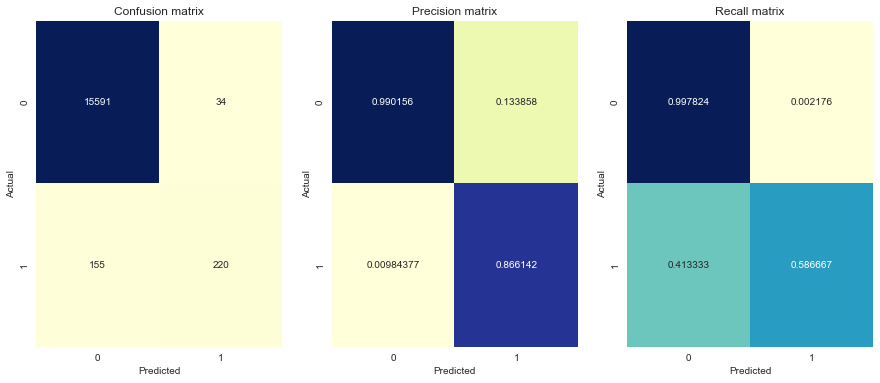

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.8435398983563278
Test F-1 Score: 0.846749189998013
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 212420
Test Misclassification cost: 77840


In [38]:
# training with best value of alpha
lr = SGDClassifier(loss='log', alpha=1e-6)
lr.fit(mice_train, Y)
# evaluating performance
evaluate_performance(lr, mice_train, Y, mice_test, Y_test)

Logistic Regression on the mice imputed dataset performs better as compared to the knn imputed dataset. It has a higher f1 score and a lower misclassification cost than the f1 score and misclassification cost for the knn imputed dataset.

### 2. KNN

In [19]:
# hyperparameter tuning
knn = KNeighborsClassifier()
params = {'n_neighbors': [5,15,55,105,155]}
knn_gridsearch = tuner(mice_train, Y, knn, params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_neighbors': 5}
F1 score: 0.7859877084745021
Time taken: 0:12:29.463436


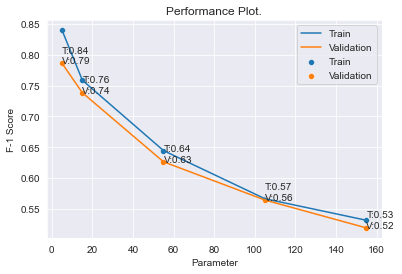

In [20]:
# performance curve
performance_curve(knn_gridsearch, params['n_neighbors'])

n_neighbors = 5 gives the best performance.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


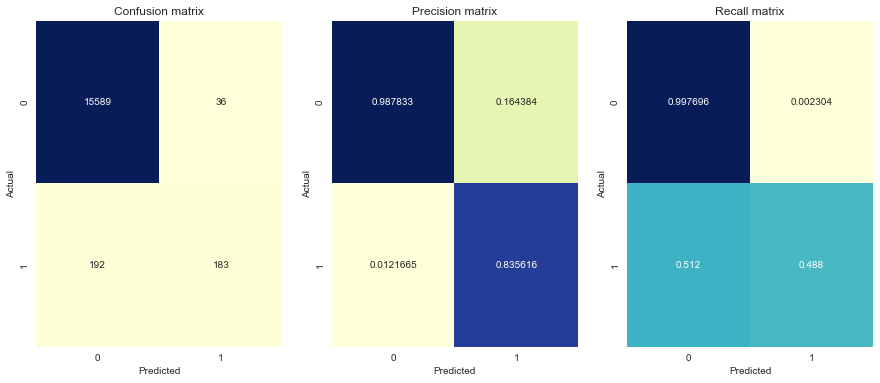

----------------------------------------------------------------------------------------------------
F-1 Score: 0.8044509284399751
----------------------------------------------------------------------------------------------------
Misclassification cost: 96360


In [21]:
# fitting the best model
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(mice_train, Y)
# evaluating the model
evaluate_performance(knn, mice_train, Y, mice_test, Y_test)

Just like on the knn imputed dataset, KNN here also performs worst with a F-1 score of 0.80 and a misclassification cost of 96360. However, its performance on the mice imputed dataset is better as compared to its performance on the knn imputed dataset.

### 4. Decision Trees

In [22]:
# hyperparameter tuning
dt = DecisionTreeClassifier()
params = {'max_depth':[3, 5, 15, 50, 150, 300]}
dt_gridsearch = tuner(mice_train, Y, dt, params)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 15}
F1 score: 0.846478143133258
Time taken: 0:00:29.373579


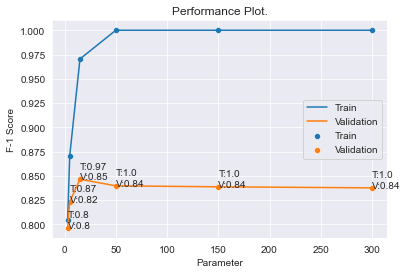

In [23]:
# plotting performance plot
performance_curve(dt_gridsearch, params['max_depth'])

The best value for this would be _max_depth=5_.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


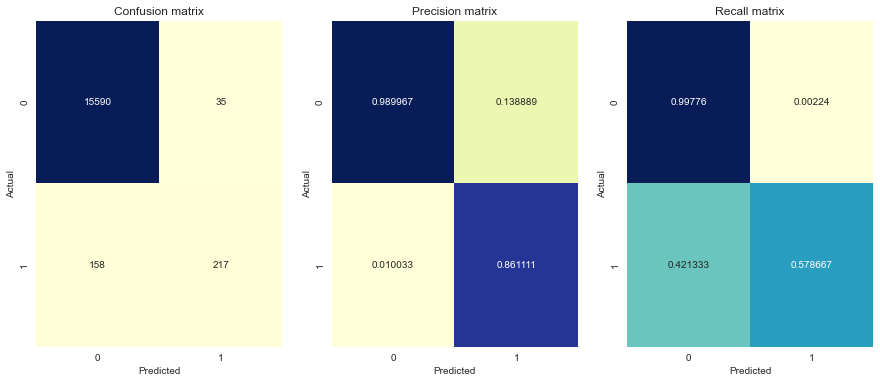

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.8735955686140244
Test F-1 Score: 0.8430166107032068
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 173880
Test Misclassification cost: 79350


In [39]:
# retraining the best model
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(mice_train, Y)
# performance report
evaluate_performance(dt, mice_train, Y, mice_test, Y_test)

The Decision Tree model tends has a misclassification cost of 79,840 and a f1 score of 0.84 for the mice imputed dataset which is better than that for the knn imputed dataset.

### 3. Random Forest

In [33]:
# hyperparameter tuning
rf = RandomForestClassifier(n_jobs=-1, max_depth=7)
params = {'n_estimators':[3, 5, 10, 50, 100, 200, 500]}
rf_gridsearch = tuner(mice_train, Y, rf, params)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Parameters: {'n_estimators': 50}
F1 score: 0.8557329747434625
Time taken: 0:00:43.346496


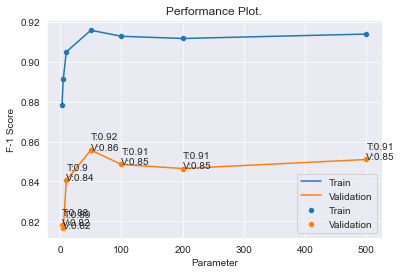

In [34]:
# plot the performance plot
performance_curve(rf_gridsearch, params['n_estimators'])

_n-estimators=50_ seems to be a good value.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


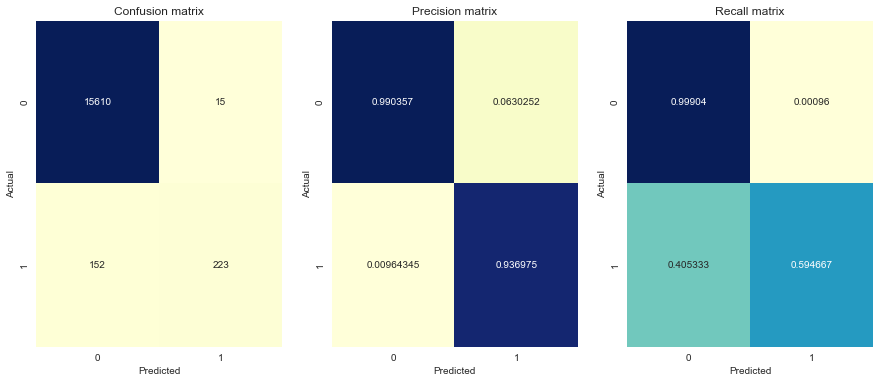

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9033546484207424
Test F-1 Score: 0.8611243284968875
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 157090
Test Misclassification cost: 76150


In [40]:
# training the best model
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=7)
rf.fit(mice_train, Y)
# evaluating performance
evaluate_performance(rf, mice_train, Y, mice_test, Y_test)

Random Forest model for the mice data performs more or less identically to the random forest on the knn data. It has the slightly higher f1 score but the exact same misclassification cost.

### 4. XGBoost

In [39]:
# hyperparameter tuning
xgbc = XGBClassifier(n_jobs=-1, max_depth=2)
params = {'n_estimators':[3,5,25,50,100]} # number of base learners
xgb_gridsearch = tuner(mice_train, Y, xgbc, params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'n_estimators': 100}
F1 score: 0.8891093831449594
Time taken: 0:00:24.831886


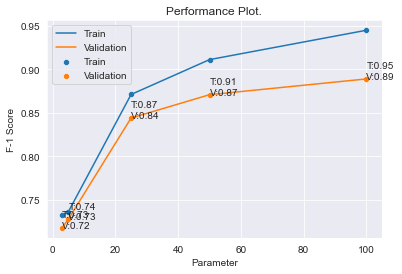

In [41]:
performance_curve(xgb_gridsearch, params['n_estimators'])

n_estimators = 50 seems to be the best hyperparameter for modelling.

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


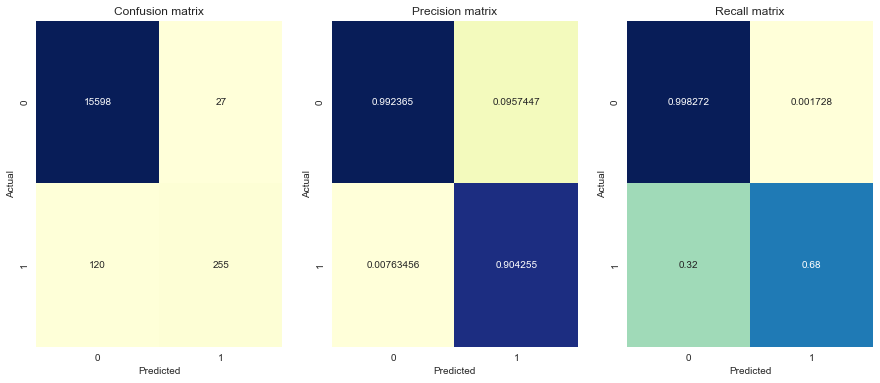

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9036957856369403
Test F-1 Score: 0.8857828326644199
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 137660
Test Misclassification cost: 60270


In [41]:
# training the best model
xgbc = XGBClassifier(n_estimators=50, n_jobs=-1, max_depth=2)
xgbc.fit(mice_train, Y)

# performance evaluation
evaluate_performance(xgbc, mice_train, Y, mice_test, Y_test)

The XGBoost model here too, performs the best with an f1 score of 0.88 and a misclassification cost of 60270.

## The performance of various models for the mice imputed data summarized:

In [11]:
from prettytable import PrettyTable

x = PrettyTable(field_names=['Model', 'Test F1-score', 'Test Misclassification Cost', 'Positive class Recall', 'FN', 'FP'])
x.add_row(['Baseline Model', '0.49', '188670', '0.01', '371', '317'])
x.add_row(['Logistic Regression', '0.84', '77840', '0.58', '155', '34'])
x.add_row(['KNN', '0.80', '96360', '0.48', '192', '36'])
x.add_row(['Decision Trees', '0.84', '79350', '0.57', '158', '35',])
x.add_row(['Random Forests', '0.86', '76150', '0.59', '152', '15'])
x.add_row(['XGBoost', '0.88', '60270', '0.68', '120', '27'])

print(x)

+---------------------+---------------+-----------------------------+-----------------------+-----+-----+
|        Model        | Test F1-score | Test Misclassification Cost | Positive class Recall |  FN |  FP |
+---------------------+---------------+-----------------------------+-----------------------+-----+-----+
|    Baseline Model   |      0.49     |            188670           |          0.01         | 371 | 317 |
| Logistic Regression |      0.84     |            77840            |          0.58         | 155 |  34 |
|         KNN         |      0.80     |            96360            |          0.48         | 192 |  36 |
|    Decision Trees   |      0.84     |            79350            |          0.57         | 158 |  35 |
|    Random Forests   |      0.86     |            76150            |          0.59         | 152 |  15 |
|       XGBoost       |      0.88     |            60270            |          0.68         | 120 |  27 |
+---------------------+---------------+-------

## Summary/Observations of the models from both the datasets:

- Predicting the negative class datapoint correctly is very easy and the main challenge boils down to correctly predict the datapoints of the positive class points and the model that does this best will be selected.
- For comparision between models, the metrics with higher weightage will be the misclassification cost and the recall for positive class.
- All the models perform much better than the baseline model.
- As expected, more complex models like Random Forests and XGBoost perform best among others for both the kinds of datasets.
- KNN Classifier performs worst among all in both the cases. One reason for this might be that, as we saw in the t-SNE plot of the datasets, the clusters of both the classes are highly intermixed. Thus, it might be possible that the nearest neighbours of a lot of positive class points are negative class points and hence it is giving the KNN model trouble.
- For the simpler models such as logistic regression and KNN, the mice imputation seems to work better than the knn imputation.
- The largest improvement in the above case is in the misclassification cost. In the case of KNN, it is largest and there is a considerable improvement in the other metrics, i.e., f1 score and recall for positive class. However, the difference between those two in the case of Logistic Regression is very small and there is also a _relatively smaller_ improvement in the misclassification cost of about 10,000.
- However, this is not the case for Random Forest and XGBoost. Ther performance is more or less similar for both with a small improvement in performance in the mice imputed dataset.
- One thing to note is that, performance of Tree based ensemble models like Random Forest and XGBoost is sensitive to some hyperparameters and their performance is impacted quite a lot by them. In the case of both of them, these are n_estimators and depth of each learner.
- Tree based ensembles and Decision Trees can overfit very quicly.
- As a result, I have decided to use the Random forest and XGBoost models for further analysis. 
- Let us perform some more extensive hyperparameter tuning on the xgboost and randomforest models for both the datasets and then we'll use the best one for further analysis.

<hr style="border:0.8px solid black"> </hr>
Now, let us perform some more extensive hyperparameter tuning of the models on a number of hyperparameters, as opposed to just one like we have done untill now. We will use multiple metrics to assess the performance as well.
Also, till now, our models have only used the default probability score of 0.5 to make predicitons. Let us also tune this to see if tuning this threshold also improves the model, especially the performance of the positive class datapoints. 
<br>We are going to use f1 score and AUC score this time to tune the models.

In [171]:
def print_auc(model, x_train, y_train, x_test, y_test):
    '''
        This function prints the roc-auc score for train and test data.
    '''
    # prediction scres
    pred_train = model.predict_proba(x_train)[:,1]
    pred_test = model.predict_proba(x_test)[:,1]
    
    # scores
    print("Train auc:", roc_auc_score(y_train, pred_train))
    print("Test auc:", roc_auc_score(y_test, pred_test))

In [39]:
# metrics to use
scoring = ['f1_macro', 'roc_auc']

### 1. Tuning Random Forest
#### 1. KNN Imputed Dataset

In [61]:
# model
rf = RandomForestClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[3,5,10,20]}

In [66]:
# random search
rf_randomsearch = RandomizedSearchCV(rf, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
rf_randomsearch.fit(knn_train, Y)
print(rf_randomsearch.best_params_)
print(rf_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'n_estimators': 50, 'max_depth': 20}
0.8866031805847764


In [71]:
# getting the results
results = pd.DataFrame(rf_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,50,10,0.955834,0.865270,0.993317,0.986871
1,5,5,0.856090,0.816919,0.970942,0.969658
2,20,20,0.993952,0.881643,0.999982,0.978183
3,3,5,0.829657,0.771991,0.962448,0.954592
4,100,5,0.856020,0.819153,0.986335,0.983226
5,50,5,0.860795,0.820911,0.985925,0.982496
6,100,10,0.958516,0.872822,0.994524,0.987884
7,5,20,0.982697,0.852532,0.998987,0.934944
8,20,5,0.853909,0.813171,0.982914,0.978623
9,3,10,0.924660,0.829358,0.988589,0.959688


As we can see, the roc scores are pretty much the same for the all the hyperparameters. Thus, we are going to only tune based on the f1 scores

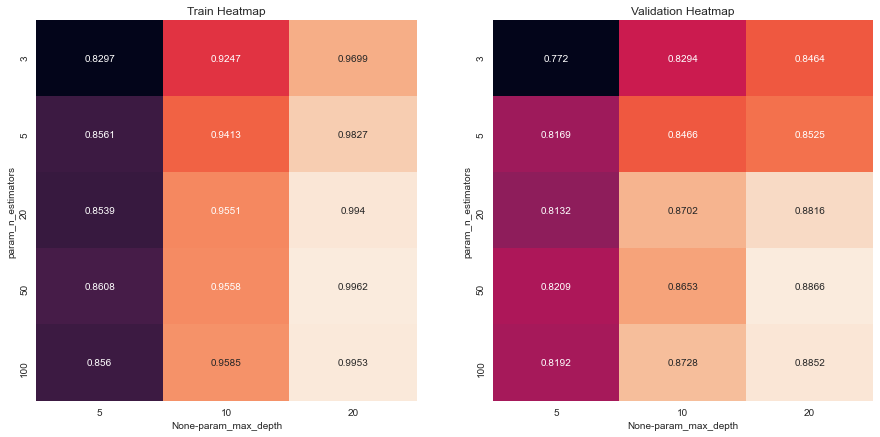

In [123]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,10,20], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,10,20], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- The roc auc score seems to be pretty high and constant for various hyperparameters.
- n_estimators=20, max_depth=10 seems to be a good value with a train f1 score of 0.95 and a validation value of 0.87.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


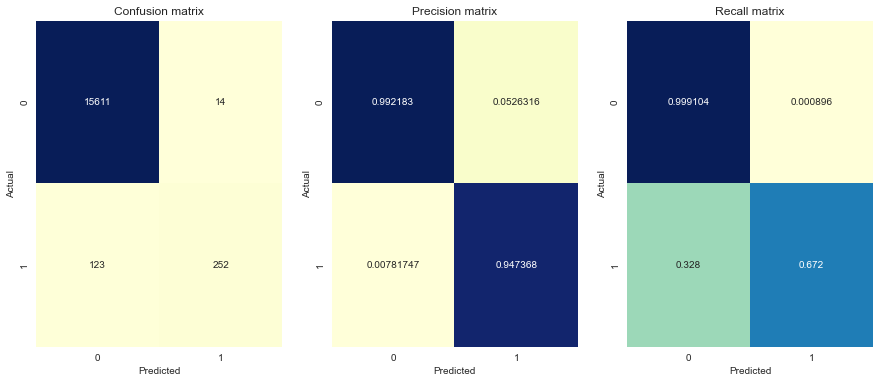

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9454694593274405
Test F-1 Score: 0.8909513445495248
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 97000
Test Misclassification cost: 61640
Train auc: 0.991445966101695
Test auc: 0.9908985173333336


In [207]:
# training the best model
rf = RandomForestClassifier(max_depth=10, n_estimators=30, n_jobs=-1)
rf.fit(knn_train, Y)

# performance report
evaluate_performance(rf, knn_train, Y, knn_test, Y_test)
# printing the auc scores
print_auc(rf, knn_train, Y, knn_test, Y_test)

We can see that the performance has improved, especially in the misclassification cost. Now, lets find the optimal prediction threshold and see if changing that further improves the model.

In [1]:
def cost_vs_tresh(tresh, predict_proba, y_test):
    '''
        This function calculates the cost for all the tresholds given by the roc curve.
    '''
    costs = []
    f1_scores = []
    # https://stackoverflow.com/questions/23200518/scikit-learn-roc-curve-why-does-it-return-a-threshold-value-2-some-time
    # sklearn adds a value greater than 1 at first to construct the complete roc curve since you need a point with 0 tpr and fpr 
    # to complete the curve
    tresh = tresh[1:] 
    for t in tqdm(tresh):
        # making predictions
        pred_bools = predict_proba >= np.ones(len(y_test))*t
        preds = np.array(list(map(lambda x:int(x), pred_bools)))
        # calculating misclassification score for that
        cost = misclassification_score(y_test, preds)
        costs.append(cost)
        # calculating f1 score
        f1 = f1_score(y_test, preds, average='macro')
        f1_scores.append(f1)
        
    # plotting the cost vs threshold curve
    fig, ax = plt.subplots(ncols=2, figsize=(15,6))
    sns.lineplot(x=tresh, y=costs, ax=ax[0])
    sns.lineplot(x=tresh, y=f1_scores, ax=ax[1])
    ax[0].set_xlabel('Tresholds')
    ax[0].set_ylabel('Misclassification Costs')
    ax[0].set_title('Cost vs Treshold')
    ax[1].set_xlabel('Tresholds')
    ax[1].set_ylabel('F1 Score')
    ax[1].set_title('F1 Score vs Treshold')
    plt.show()
    
    return costs, f1_scores

100%|████████████████████████████████████████████████████████████████████████████████| 486/486 [00:08<00:00, 60.06it/s]


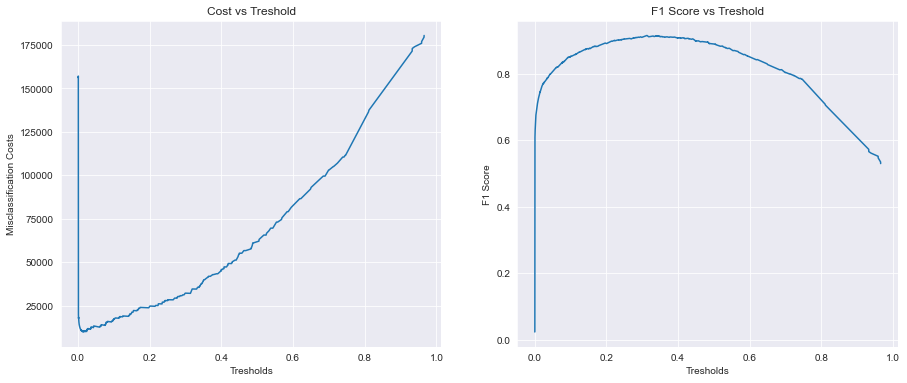

Minimum Cost: 9850
Maximum F1 Score: 0.9162788128267034


In [234]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = rf.predict_proba(knn_test)
tpr, fpr, tresh = roc_curve(Y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], Y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The minimum Misclassifcation cost is 10030 at treshold very close to 0.
- The maximum f-1 score is 0.91 for a treshold close to 0.3.
- The minimum cost may be a result of all the points being predicted to be positive and hence we are getting a lot of false Positives.
- We are going to use _treshold==0.2_ as for that value, the cost is very low and the f1 score too is high enough.

__Using the best treshold to make predictions.__

In [42]:
def treshold_predictions(treshold, scores):
    '''
        This function makes prediction based on the given treshold.
    '''
    preds_bool = scores >= np.ones(len(scores))*treshold
    preds = np.array(list(map(lambda x: int(x), preds_bool)))
    return preds

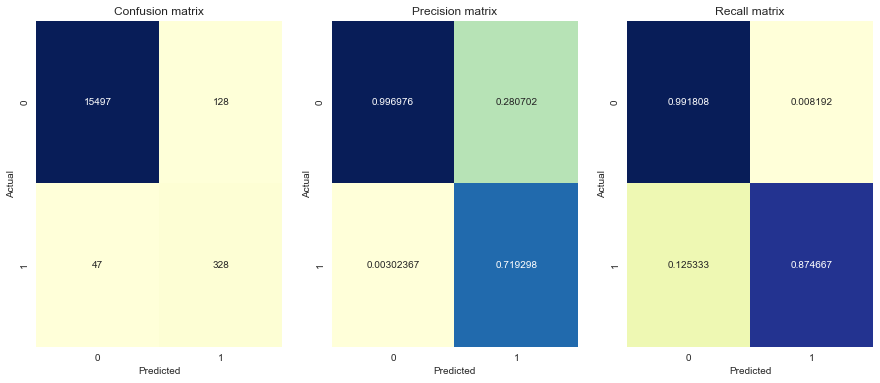

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 35300
Test Misclassification Costs: 24780
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9405046819222324
Test f-1 scores: 0.8918978980279821
----------------------------------------------------------------------------------------------------
Train AUC: 0.9649745762711864
Test AUC: 0.9332373333333334


In [246]:
# train preds
train_probs = rf.predict_proba(knn_train)[:,1]
test_probs = rf.predict_proba(knn_test)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.2, train_probs)
y_hat_test = treshold_predictions(0.2, test_probs)

# evaluate performance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(Y, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(Y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

#### 2. MICE Imputed Dataset

In [12]:
# model
rf = RandomForestClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[3,5,10,20]}

In [24]:
# random search
rf_randomsearch = RandomizedSearchCV(rf, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
rf_randomsearch.fit(mice_train, Y)
print(rf_randomsearch.best_params_)
print(rf_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'n_estimators': 100, 'max_depth': 20}
0.8865365869377951


In [26]:
# getting the results
results = pd.DataFrame(rf_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]
results

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,50,10,0.956443,0.862544,0.994203,0.985814
1,5,5,0.846584,0.807986,0.972313,0.966763
2,20,20,0.991995,0.877690,0.999984,0.985478
3,3,5,0.829444,0.796936,0.969721,0.957842
4,100,5,0.854059,0.812535,0.986004,0.982244
5,50,5,0.860422,0.822896,0.985094,0.980763
6,100,10,0.958218,0.871113,0.994165,0.987458
7,5,20,0.979186,0.857323,0.999311,0.948956
8,20,5,0.860886,0.816031,0.983047,0.978599
9,3,10,0.926648,0.848725,0.983765,0.960531


As we can see, the roc scores are pretty much the same for the all the hyperparameters. Thus, we are going to only tune based on the f1 scores.

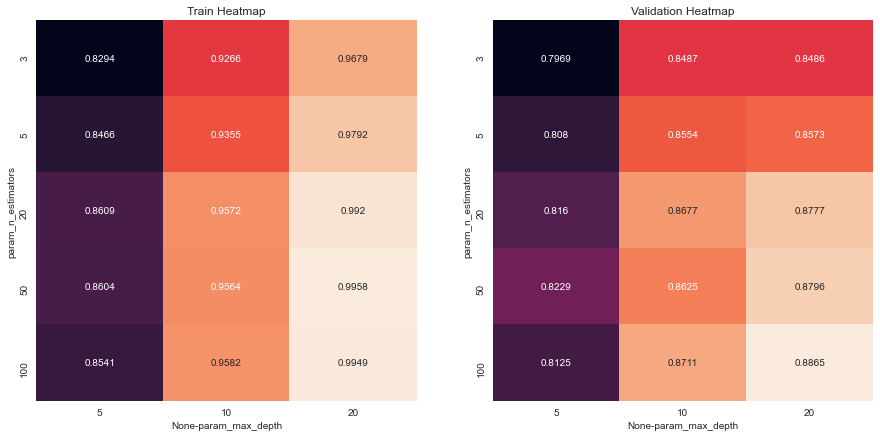

In [28]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,10,20], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,10,20], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- The roc auc score seems to be pretty high and constant for various hyperparameters.
- n_estimators=50, max_depth=10 seems to be a good value with a train f1 score of 0.95 and a validation value of 0.87.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


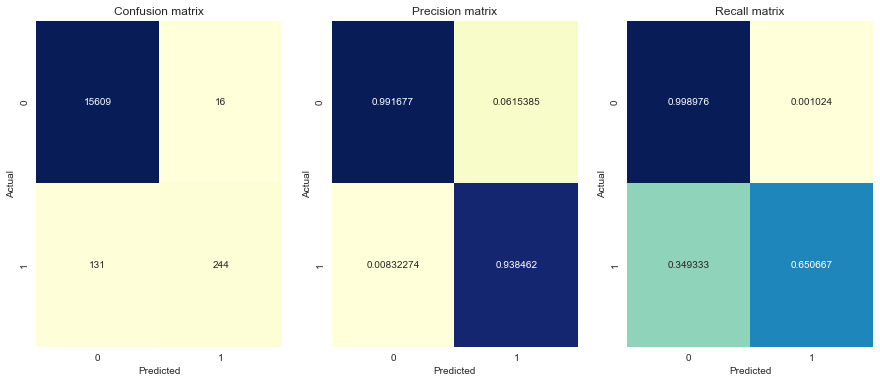

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.951922647374698
Test F-1 Score: 0.8819085921289966
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 86500
Test Misclassification cost: 65660
Train auc: 0.9930478813559322
Test auc: 0.9955001173333333


In [57]:
# training the best model
rf = RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1)
rf.fit(mice_train, Y)

# performance report
evaluate_performance(rf, mice_train, Y, mice_test, Y_test)
# printing the auc scores
print_auc(rf, mice_train, Y, mice_test, Y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 548/548 [00:09<00:00, 59.05it/s]


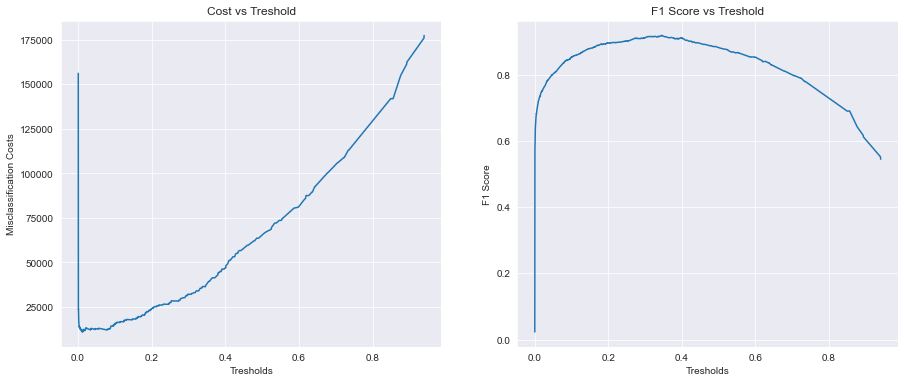

Minimum Cost: 10970
Maximum F1 Score: 0.9190110826939472


In [58]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = rf.predict_proba(mice_test)
tpr, fpr, tresh = roc_curve(Y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], Y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The minimum Misclassifcation cost is 10970 at treshold very close to 0.
- The maximum f-1 score is 0.92 for a treshold close to 0.3.
- The minimum cost may be a result of all the points being predicted to be positive and hence we are getting a lot of false Positives.
- We are going to use _treshold==0.2_ as for that value, the cost is very low and the f1 score too is high enough.

__Using the best treshold to make predictions.__

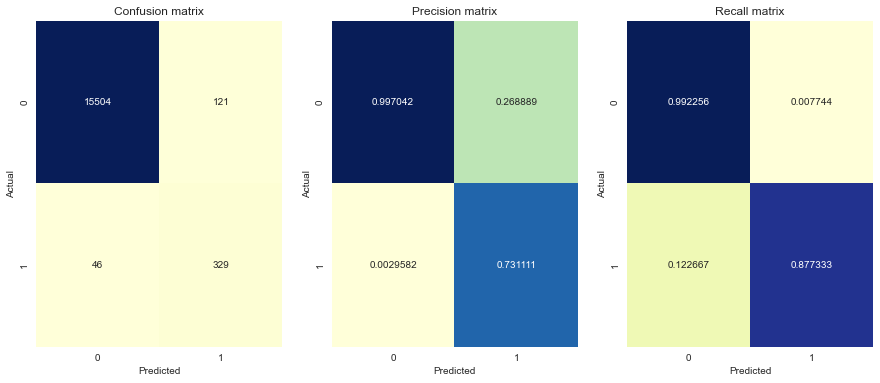

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 33290
Test Misclassification Costs: 24210
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9417902023962681
Test f-1 scores: 0.8961094505601324
----------------------------------------------------------------------------------------------------
Train AUC: 0.9669830508474576
Test AUC: 0.9347946666666667


In [74]:
# train preds
train_probs = rf.predict_proba(mice_train)[:,1]
test_probs = rf.predict_proba(mice_test)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.2, train_probs)
y_hat_test = treshold_predictions(0.2, test_probs)

# evaluate performance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(Y, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(Y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

### 2. Tuning XGBoost
#### 1. KNN Imputed Model

In [256]:
# model
xgb = XGBClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[1,3,5]}

In [257]:
# random search
xgb_randomsearch = RandomizedSearchCV(xgb, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
xgb_randomsearch.fit(knn_train, Y)
print(xgb_randomsearch.best_params_)
print(xgb_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'n_estimators': 100, 'max_depth': 5}
0.8989383599388474


In [262]:
# getting the results
results = pd.DataFrame(xgb_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]
results

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,3,1,0.657932,0.657092,0.927597,0.923634
1,5,1,0.652775,0.650041,0.943743,0.936348
2,20,1,0.745243,0.731468,0.983909,0.981594
3,50,1,0.847859,0.834915,0.988270,0.985706
4,100,1,0.882611,0.857101,0.990590,0.987938
5,3,3,0.817882,0.806567,0.943599,0.939162
6,5,3,0.831098,0.813971,0.974799,0.960392
7,20,3,0.898299,0.864168,0.992302,0.986395
8,50,3,0.957900,0.892639,0.997574,0.988876
9,100,3,0.988034,0.898275,0.999664,0.990013


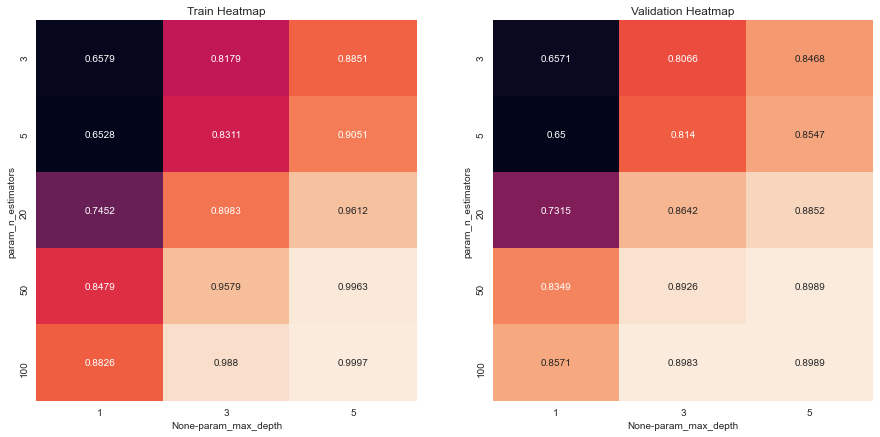

In [264]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[1,3,5], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[1,3,5], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- The roc score seems to stay more or less constant for every hyperparameter.
- n_estimators=20 and max_depth=5 seems to be the best value

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


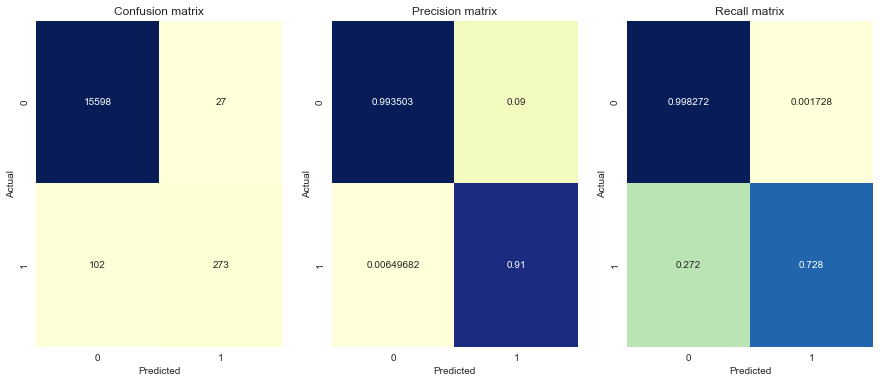

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9519876647256925
Test F-1 Score: 0.9023853861842689
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 81130
Test Misclassification cost: 51270
Train auc: 0.9959043644067797
Test auc: 0.9947892906666667


In [102]:
# training the best model
xgb = XGBClassifier(max_depth=5, n_estimators=20, n_jobs=-1)
xgb.fit(knn_train, Y)

# pexgbormance report
evaluate_performance(xgb, knn_train, Y, knn_test, Y_test)
# printing the auc scores
print_auc(xgb, knn_train, Y, knn_test, Y_test)

Here too, the performance has become better, especially for misclassification cost.<br>
Now, let us find the optimal treshold value for XGBoost.

100%|████████████████████████████████████████████████████████████████████████████████| 610/610 [00:10<00:00, 57.70it/s]


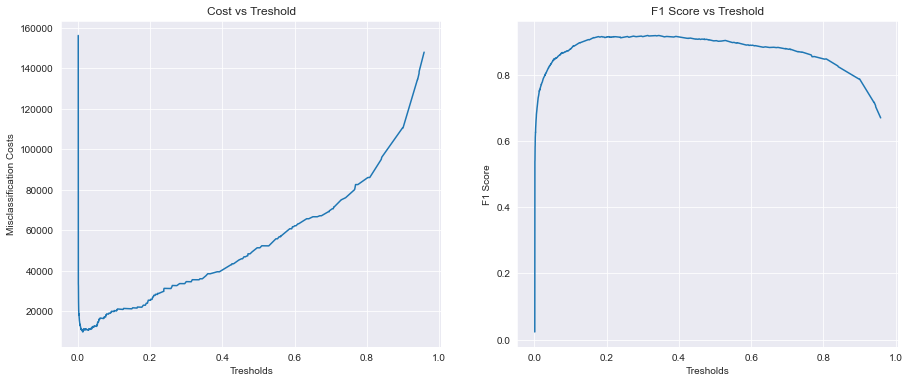

Minimum Cost: 9660
Maximum F1 Score: 0.9181017777032878


In [103]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = xgb.predict_proba(knn_test)
tpr, fpr, tresh = roc_curve(Y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], Y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The score goes below 20000 for xgboost in the best case.
- The minimum score is 9660 for treshold very close to 0.
- The maximum f1 score is 0.91 for a treshold equal to 0.15.
- We are going to choose a treshold of 0.15 for XGBoost because for that value, the cost is very low (about 20,000) and the f1 score is also high.

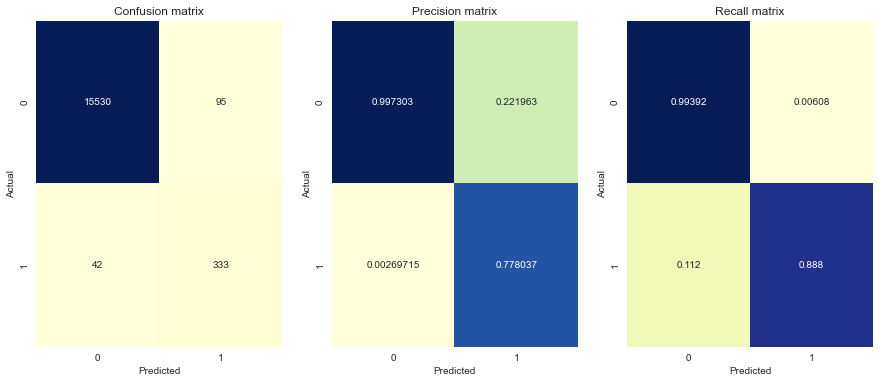

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 28570
Test Misclassification Costs: 21950
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9286203721269484
Test f-1 scores: 0.9124991701991334
----------------------------------------------------------------------------------------------------
Train AUC: 0.9718220338983051
Test AUC: 0.9409599999999999


In [106]:
# train preds
train_probs = xgb.predict_proba(knn_train)[:,1]
test_probs = xgb.predict_proba(knn_test)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.17, train_probs)
y_hat_test = treshold_predictions(0.17, test_probs)

# evaluate pexgbormance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(Y, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(Y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

#### 2. MICE Imputed Dataset

In [63]:
# model
xgb = XGBClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[1,3,5]}

In [64]:
# random search
xgb_randomsearch = RandomizedSearchCV(xgb, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
xgb_randomsearch.fit(mice_train, Y)
print(xgb_randomsearch.best_params_)
print(xgb_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:13:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'n_estimators': 100, 'max_depth': 5}
0.9029360078990858


In [65]:
# getting the results
results = pd.DataFrame(xgb_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]
results

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,3,1,0.657932,0.657092,0.927597,0.923634
1,5,1,0.652775,0.650041,0.943743,0.936348
2,20,1,0.745243,0.731468,0.983909,0.981594
3,50,1,0.848608,0.833902,0.988725,0.986410
4,100,1,0.880862,0.859248,0.991146,0.988401
5,3,3,0.817882,0.806567,0.943599,0.939162
6,5,3,0.833487,0.817049,0.974784,0.960412
7,20,3,0.901627,0.861842,0.992825,0.986869
8,50,3,0.955126,0.889504,0.997437,0.991178
9,100,3,0.988056,0.897422,0.999751,0.991037


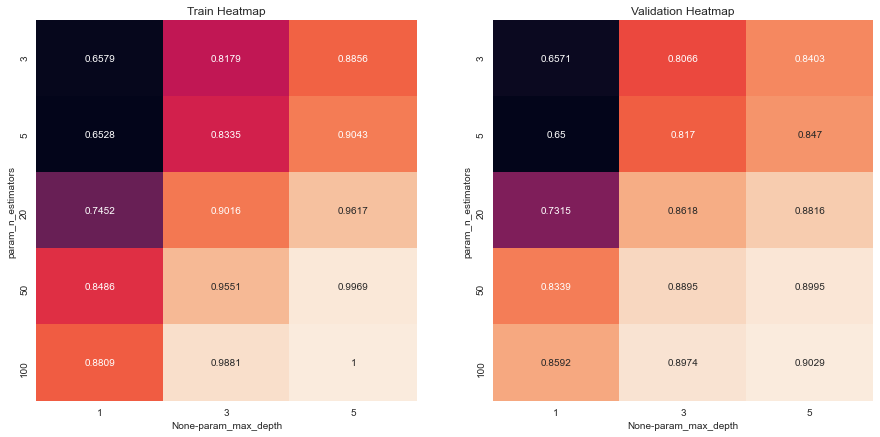

In [66]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[1,3,5], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[1,3,5], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- The roc score seems to stay more or less constant for every hyperparameter.
- n_estimators=20 and max_depth=5 seems to be the best value

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


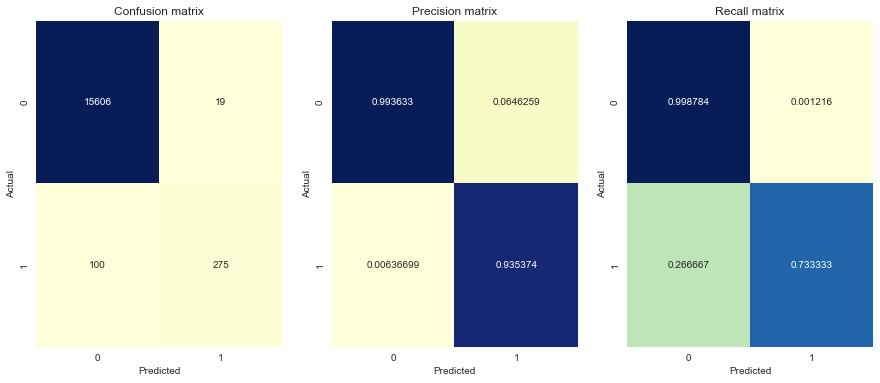

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9619230804908407
Test F-1 Score: 0.9091622079098629
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 65110
Test Misclassification cost: 50190
Train auc: 0.9986573474576271
Test auc: 0.9944910506666667


In [147]:
# training the best model
xgb = XGBClassifier(max_depth=5, n_estimators=25, n_jobs=-1)
xgb.fit(mice_train, Y)

# pexgbormance report
evaluate_performance(xgb, mice_train, Y, mice_test, Y_test)
# printing the auc scores
print_auc(xgb, mice_train, Y, mice_test, Y_test)

Here too, the performance has become better, especially for misclassification cost.<br>
Now, let us find the optimal treshold value for XGBoost.

100%|██████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:17<00:00, 57.88it/s]


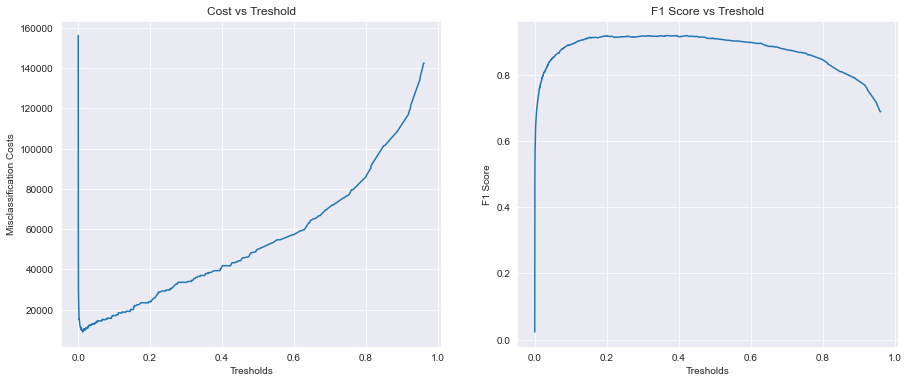

Minimum Cost: 8850
Maximum F1 Score: 0.9193370513911208


In [148]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = xgb.predict_proba(mice_test)
tpr, fpr, tresh = roc_curve(Y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], Y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The score goes below 20000 for xgboost in the best case.
- The minimum score is 8850 for treshold very close to 0.
- The maximum f1 score is 0.91 for a treshold equal to 0.15.
- We are going to choose a treshold of 0.15 for XGBoost because for that value, the cost is very low (about 20,000) and the f1 score is also high.

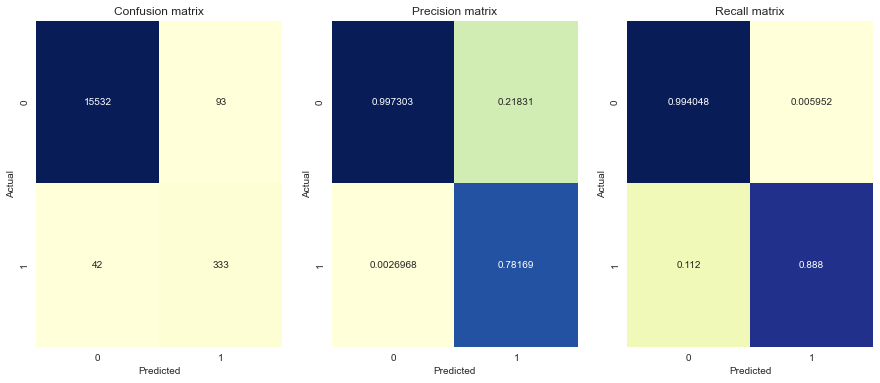

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 19450
Test Misclassification Costs: 21930
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9357220560883119
Test f-1 scores: 0.9135668061962516
----------------------------------------------------------------------------------------------------
Train AUC: 0.9809237288135594
Test AUC: 0.941024


In [151]:
# train preds
train_probs = xgb.predict_proba(mice_train)[:,1]
test_probs = xgb.predict_proba(mice_test)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.16, train_probs)
y_hat_test = treshold_predictions(0.16, test_probs)

# evaluate pexgbormance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(Y, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(Y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

## Performance Review

In [154]:
# summarizing model performance
from prettytable import PrettyTable
print('--------------------------------------------For KNN Imputed Dataset--------------------------------------------')
x = PrettyTable(field_names=['Model', 'Threshold','Test F1-score', 'Test Misclassification Cost', 'Positive Class Recall', 'FN', 'FP'])
x.add_row(['Random Forest','0.5', '0.891', '61640', '0.67', '123', '14'])
x.add_row(['Random Forest','0.2', '0.891', '24780', '0.87', '47', '128'])
x.add_row(['XGBoost', '0.5', '0.902', '51270', '0.72', '102', '27'])
x.add_row(['XGBoost', '0.15', '0.914', '22910', '0.88', '44', '91'])

print(x)

print("--------------------------------------------For MICE Imputed Dataset--------------------------------------------")
x = PrettyTable(field_names=['Model', 'Threshold','Test F1-score', 'Test Misclassification Cost', 'Positive Class Recall', 'FN', 'FP'])
x.add_row(['Random Forest','0.5', '0.881', '65660', '0.65', '131', '16'])
x.add_row(['Random Forest','0.2', '0.891', '24210', '0.87', '46', '121'])
x.add_row(['XGBoost', '0.5', '0.909', '50190', '0.73', '100', '19'])
x.add_row(['XGBoost', '0.16', '0.914', '21930', '0.88', '42', '93'])


print(x)

--------------------------------------------For KNN Imputed Dataset--------------------------------------------
+---------------+-----------+---------------+-----------------------------+-----------------------+-----+-----+
|     Model     | Threshold | Test F1-score | Test Misclassification Cost | Positive Class Recall |  FN |  FP |
+---------------+-----------+---------------+-----------------------------+-----------------------+-----+-----+
| Random Forest |    0.5    |     0.891     |            61640            |          0.67         | 123 |  14 |
| Random Forest |    0.2    |     0.891     |            24780            |          0.87         |  47 | 128 |
|    XGBoost    |    0.5    |     0.902     |            51270            |          0.72         | 102 |  27 |
|    XGBoost    |    0.15   |     0.914     |            22910            |          0.88         |  44 |  91 |
+---------------+-----------+---------------+-----------------------------+-----------------------+-----

- Performing more extensive hyperparameter tuning of the model made it perform slightly well.
- Selecting the best treshold for prediction based om cost and F-1 Score increased the model performance by a lot.
- The slight overfitting on the f1 score in both the models (especially Random Forest), is solved here as the train and test f1 scores are much closer and even slightly greater now.
<hr style="border:0.75px solid gray"> </hr>

__Choosing between the knn and mice imputation techniques__
- The mice imputed dataset gives better performance before and after tuning the prediction threshold. However, this improvement is not very significant.
- However, it should be noted that the KNNImputer is very slow as it uses KNN algorithm for making predictions which is inherently very slow and can not be used for low latency tasks, while MICE imputation is relatively faster.
- Thus, I have decided to use MICE imputed data for further modelling keeping in mind the time required for imputation.

# Modelling on the feature engineered datasets.
Now we are going to train the models on the feature engineered dataset and see if there is any improvement in the performance. We are going to train random forests and XGBoost on these datasets. We will be using the knn imputed version of the datasets. 
__For simplicity, let's call the features (except AutoEncoder encodings) anomaly features.__

Here too, we will tune the model's parameters and the tresholds and try to get the best performance possible out of the model.

Here, we will use the mice imputations.

In [163]:
# loading the datasets
train = pd.read_csv("Saves\\Datasets\\train_mice_normalized.csv")
test = pd.read_csv('Saves//Datasets\\test_mice_normalized.csv')

x_train = train.drop(columns='class')
y_train = train['class']

x_test = test.drop(columns='class')
y_test = test['class']

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(60000, 195) (16000, 195)
(60000,) (16000,)


In [131]:
# changing class labels from 'pos' and 'neg' to 0 and 1
y_train = np.array([1 if i=='pos' else 0 for i in y_train])
y_test = np.array([1 if i=='pos' else 0 for i in y_test])

In [132]:
x_train.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,al_000_75,aq_000_25,aq_000_50,aq_000_75,ap_000_25,ap_000_50,ap_000_75,cn_000_25,cn_000_50,cn_000_75
0,0.027925,9.999998e-01,3.261769e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000163,...,0.000000,0.044285,0.044285,0.044285,0.022660,0.022660,0.022660,0.0,0.0,0.0
1,0.012036,0.000000e+00,2.427688e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000080,...,0.000000,0.013244,0.013244,0.013244,0.013917,0.013917,0.013917,0.0,0.0,0.0
2,0.014942,1.070067e-07,1.164918e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000007,...,0.000000,0.006013,0.006013,0.006013,0.003860,0.003860,0.003860,0.0,0.0,0.0
3,0.000004,3.285295e-08,7.688457e-09,0.0,0.000498,0.0,0.0,0.0,0.000005,0.000010,...,0.000018,0.000040,0.000040,0.000040,0.000138,0.000138,0.000138,0.0,0.0,0.0
4,0.022164,6.420405e-07,5.335323e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000191,...,0.000000,0.021556,0.021556,0.021556,0.013577,0.013577,0.013577,0.0,0.0,0.0


On doing some visual inspection of the dataset, I found out that the histogram features of the important features have exact same values of the 25th, 50th and 75th percentile for a given row for a given feature. This is not due to any errors during feature engineering and/or normalization, normalizing these features gave same values. As a result, I have decided to remove two out of the three histogram features for each feature and save it on the disk.

In [133]:
# getting all the histogram features
columns = x_train.columns
histogram_features = [fn for fn in columns if fn.endswith('25') or fn.endswith('50') or fn.endswith('75')]
print("Histogram feature names:-", *histogram_features, sep='\t')
print('-'*100)
removable = [fn for fn in histogram_features if fn.endswith('25') or fn.endswith('75')]
print("Features to be removed:", *removable, sep='\t')

Histogram feature names:-	ag_002_25	ag_002_50	ag_002_75	ck_000_25	ck_000_50	ck_000_75	bb_000_25	bb_000_50	bb_000_75	ci_000_25	ci_000_50	ci_000_75	bj_000_25	bj_000_50	bj_000_75	am_0_25	am_0_50	am_0_75	al_000_25	al_000_50	al_000_75	aq_000_25	aq_000_50	aq_000_75	ap_000_25	ap_000_50	ap_000_75	cn_000_25	cn_000_50	cn_000_75
----------------------------------------------------------------------------------------------------
Features to be removed:	ag_002_25	ag_002_75	ck_000_25	ck_000_75	bb_000_25	bb_000_75	ci_000_25	ci_000_75	bj_000_25	bj_000_75	am_0_25	am_0_75	al_000_25	al_000_75	aq_000_25	aq_000_75	ap_000_25	ap_000_75	cn_000_25	cn_000_75


In [134]:
# droppping these from the dataframes and saving
# train
x_train = x_train.drop(columns=removable)
# test
x_test = x_test.drop(columns=removable)

# saving
if os.path.isfile('Saves\\Datasets\\x_train_final.csv') and os.path.isfile('Saves\\Datasets\\x_test_final.csv'):
    x_train.to_csv('Saves\\Datasets\\x_train_final.csv', index=False)
    x_test.to_csv('Saves\\Datasets\\x_test_final.csv', index=False)

In [155]:
# loading the encoder generated features for train and test sets
def pickle_loader(filepath):
    '''
        This function loads and returns the pickle object saved at the filepath.
    '''
    with open(filepath, 'rb') as f:
        FO = pickle.load(f)
    return FO

In [72]:
# loading the train encodings
encoding_train = pickle_loader('Saves\\Datasets\\Feature Encodings\\enc_mice_tr_norm.pickle')
# loading the test encodings
encoding_test = pickle_loader('Saves\\Datasets\\Feature Encodings\\enc_mice_te_norm.pickle')

print(encoding_train.shape, encoding_test.shape)

(60000, 40) (16000, 40)


In [73]:
# appending encodings to the dataset
x_train_enc = np.hstack([x_train.values, encoding_train])
x_test_enc = np.hstack([x_test.values, encoding_test])

print(x_train_enc.shape, x_test_enc.shape)

(60000, 215) (16000, 215)


### 1. Random Forest (W/O Encodings)

In [30]:
# model
rf = RandomForestClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[3,5,10,20]}

In [34]:
# random search
rf_randomsearch = RandomizedSearchCV(rf, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
rf_randomsearch.fit(x_train, y_train)
print(rf_randomsearch.best_params_)
print(rf_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'n_estimators': 100, 'max_depth': 20}
0.8847760114137174


In [35]:
# getting the results
results = pd.DataFrame(rf_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]
results

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,50,10,0.957035,0.872441,0.993843,0.985964
1,5,5,0.854298,0.813591,0.974879,0.964272
2,20,20,0.994349,0.884507,0.999990,0.977788
3,3,5,0.842648,0.810966,0.969746,0.958310
4,100,5,0.863686,0.823599,0.986774,0.982679
5,50,5,0.861506,0.819695,0.984158,0.981832
6,100,10,0.958071,0.873621,0.995065,0.987939
7,5,20,0.979137,0.860208,0.999830,0.935868
8,20,5,0.853726,0.816687,0.984515,0.979166
9,3,10,0.931534,0.837956,0.987053,0.968521


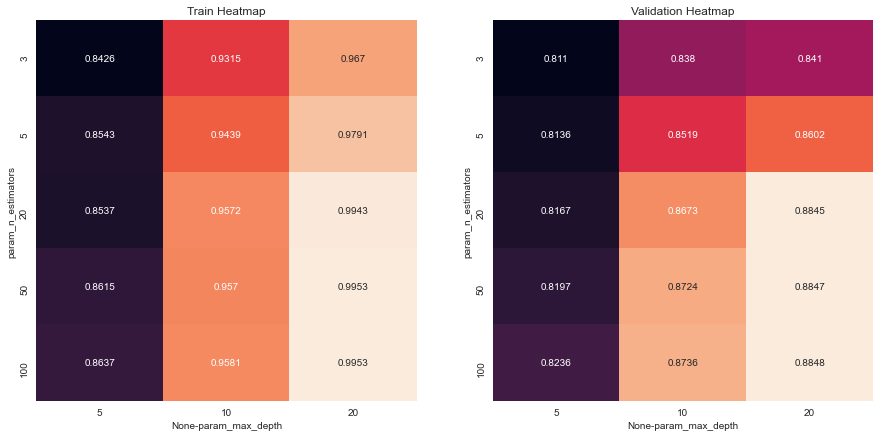

In [36]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,10,20], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,10,20], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- AUC score doesnt change much no matter the hyperparameter, hence we will only be comparing f1 scores
- Random forest with <i>n_estimators==100 and max_depth=10</i> seems to be the best parameter values

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


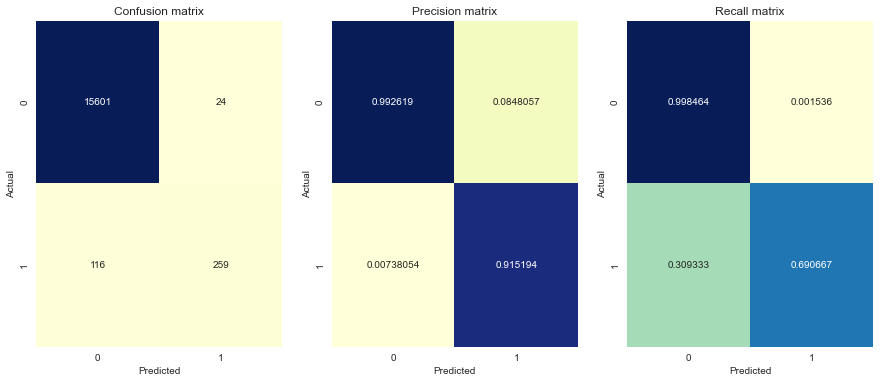

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9652701806297905
Test F-1 Score: 0.8913835964791992
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 64000
Test Misclassification cost: 58240
Train auc: 0.9928284915254235
Test auc: 0.995698432


In [103]:
# training random forest with best parameters
rf = RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1)
rf.fit(x_train, y_train)

# performance report
evaluate_performance(rf, x_train, y_train, x_test, y_test)
# printing the auc scores
print_auc(rf, x_train, y_train, x_test, y_test)

- After using features, the Random Forest model performs better.
- The misclassification cost was reduced and recall for the positive class was improved.
- However, the f1 score for train and test set were similar for both the cases.

Now, lets find the best threshold for splitting.

100%|████████████████████████████████████████████████████████████████████████████████| 588/588 [00:09<00:00, 59.60it/s]


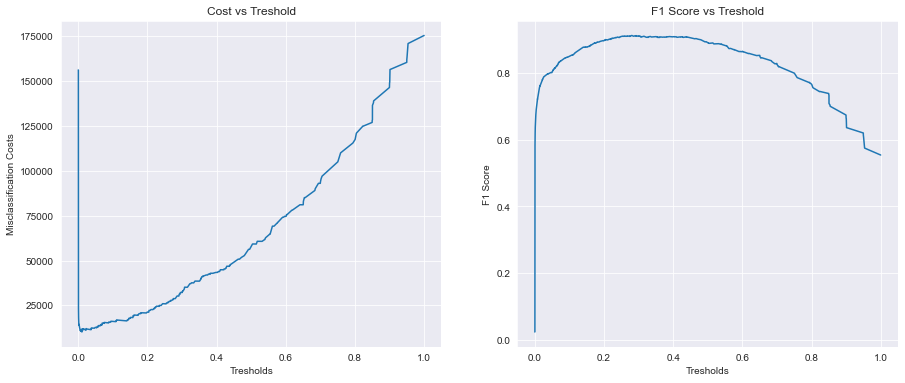

Minimum Cost: 10160
Maximum F1 Score: 0.9138410043433902


In [104]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = rf.predict_proba(x_test)
tpr, fpr, tresh = roc_curve(y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The minimum misclassification cost is 10610 for a treshold very close to 0.
- The maximum f1 score is 0.91 for a treshold in the range 0.3-0.4.
- A threshold of 0.2 seems to be good since we have a good f1 score and a low misclassification cost for it.

### Using best theshold to make predictions

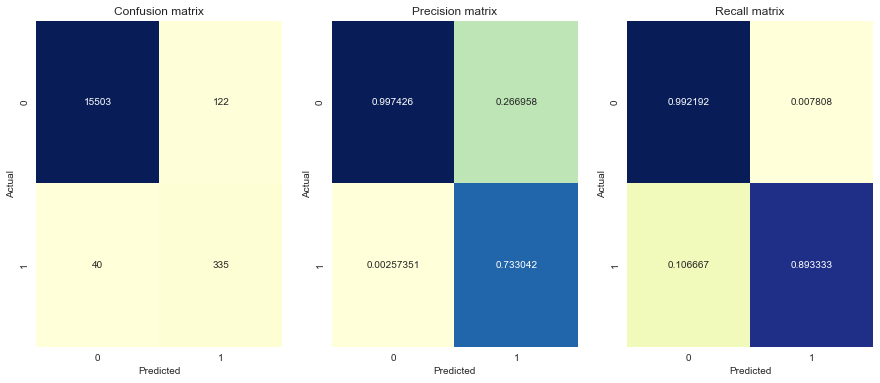

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 25570
Test Misclassification Costs: 21220
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9505293199870126
Test f-1 scores: 0.9000454114673827
----------------------------------------------------------------------------------------------------
Train AUC: 0.9746694915254237
Test AUC: 0.9427626666666666


In [106]:
# train preds
train_probs = rf.predict_proba(x_train)[:,1]
test_probs = rf.predict_proba(x_test)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.20, train_probs)
y_hat_test = treshold_predictions(0.20, test_probs)

# evaluate performance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(y_train, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

### 2. Random Forest (With Encodings)

In [107]:
# model
rf = RandomForestClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[5,12,15]}

In [108]:
# random search
rf_randomsearch = RandomizedSearchCV(rf, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
rf_randomsearch.fit(x_train_enc, y_train)
print(rf_randomsearch.best_params_)
print(rf_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'n_estimators': 50, 'max_depth': 15}
0.8792134887276944


In [109]:
# getting the results
results = pd.DataFrame(rf_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]
results

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,3,5,0.844521,0.809727,0.964046,0.952086
1,5,5,0.839296,0.798425,0.969703,0.961299
2,20,5,0.860530,0.814884,0.982273,0.977897
3,50,5,0.853024,0.811317,0.987266,0.982710
4,100,5,0.861532,0.815454,0.986237,0.983010
5,3,12,0.949519,0.834229,0.989781,0.952546
6,5,12,0.957437,0.849779,0.990999,0.979317
7,20,12,0.970883,0.873806,0.996217,0.985347
8,50,12,0.970961,0.870981,0.997442,0.987209
9,100,12,0.972251,0.870093,0.998810,0.989253


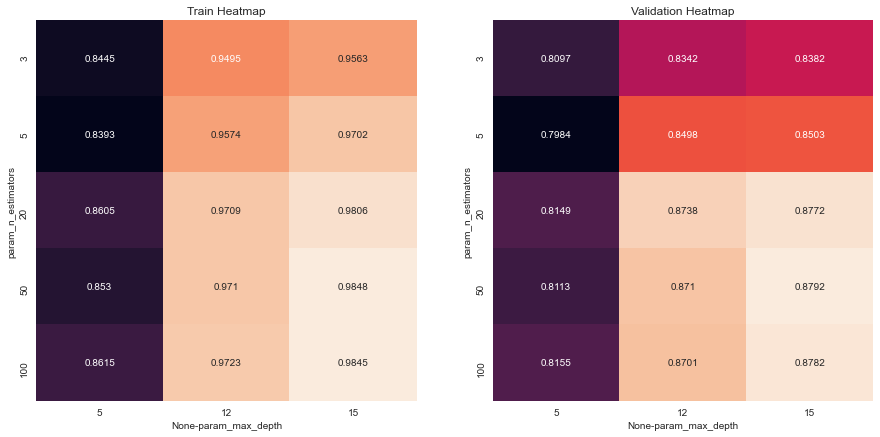

In [112]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,12,15], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[5,12,15], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- The parameters <i>max_depth==12 and n_estimators==20</i> seem to be the best values.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


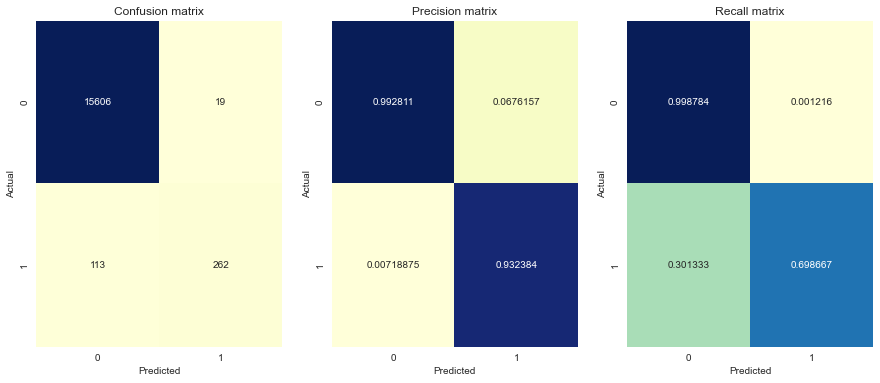

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9670367675137437
Test F-1 Score: 0.8972845777462369
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 60510
Test Misclassification cost: 56690
Train auc: 0.9963471779661017
Test auc: 0.9952948053333334


In [122]:
# training the best model
rf = RandomForestClassifier(max_depth=12, n_estimators=20, n_jobs=-1)
rf.fit(x_train_enc, y_train)

# performance report
evaluate_performance(rf, x_train_enc, y_train, x_test_enc, y_test)
# printing the auc scores
print_auc(rf, x_train_enc, y_train, x_test_enc, y_test)

### Some observations from using anomaly features.
- The performance of anomaly features and encodings together is better than using anomaly feature set alone.
- The misclassification cost was reduced while the f1 scores remained same and recall for positive class improved.

Lets tune and find the best threshold value.

100%|████████████████████████████████████████████████████████████████████████████████| 574/574 [00:09<00:00, 59.06it/s]


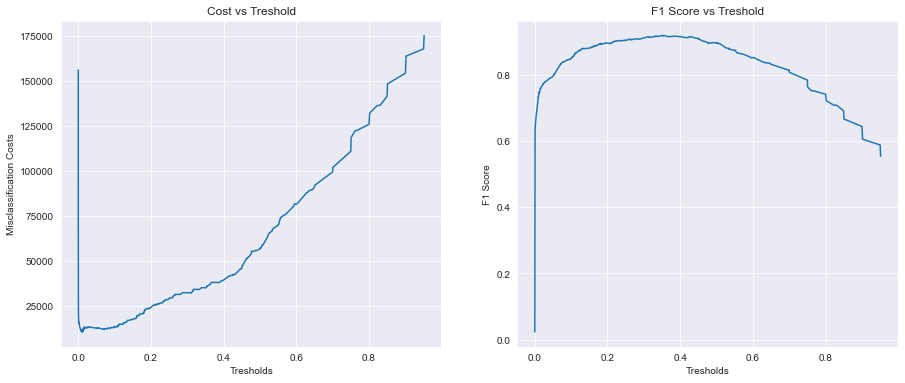

Minimum Cost: 10310
Maximum F1 Score: 0.9202624107610464


In [123]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = rf.predict_proba(x_test_enc)
tpr, fpr, tresh = roc_curve(y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The maximum f1 score is 0.92 for threshold approximately equal to 0.15.
- The minimum cost is 10310 for a threshold very close to 0.
- A threshold value close to 0.20 is going to be a good choice since the f1 score for that threshold too is close to 0.90 and the cose is also very low.
- Lets choose the threshold to be equal to 0.20.

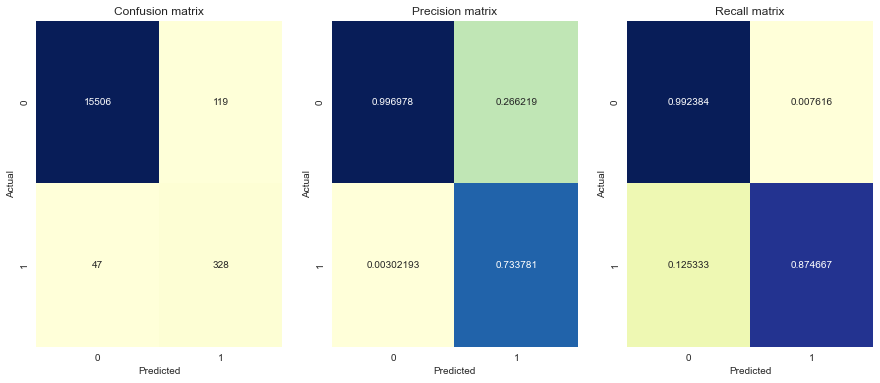

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 22890
Test Misclassification Costs: 24690
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9558121551082055
Test f-1 scores: 0.8963646304345553
----------------------------------------------------------------------------------------------------
Train AUC: 0.9773220338983051
Test AUC: 0.9335253333333334


In [128]:
# train preds
train_probs = rf.predict_proba(x_train_enc)[:,1]
test_probs = rf.predict_proba(x_test_enc)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.2, train_probs)
y_hat_test = treshold_predictions(0.2, test_probs)

# evaluate performance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(y_train, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

### 3. XGBoost (W/O Encodings)

In [161]:
# model
xgb = XGBClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[2,3,5]}

In [162]:
# random search
xgb_randomsearch = RandomizedSearchCV(xgb, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
xgb_randomsearch.fit(x_train, y_train)
print(xgb_randomsearch.best_params_)
print(xgb_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'n_estimators': 100, 'max_depth': 5}
0.9045159414150795


In [163]:
# getting the results
results = pd.DataFrame(xgb_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]
results

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,3,2,0.731898,0.717554,0.939281,0.935570
1,5,2,0.736073,0.727549,0.961956,0.952494
2,20,2,0.854153,0.837415,0.988510,0.984165
3,50,2,0.910687,0.870621,0.993638,0.988479
4,100,2,0.947480,0.891016,0.996671,0.989041
5,3,3,0.817882,0.806567,0.943599,0.939162
6,5,3,0.831764,0.816348,0.974796,0.960404
7,20,3,0.898618,0.862928,0.992721,0.986816
8,50,3,0.958365,0.889185,0.997557,0.989370
9,100,3,0.988311,0.899998,0.999732,0.990011


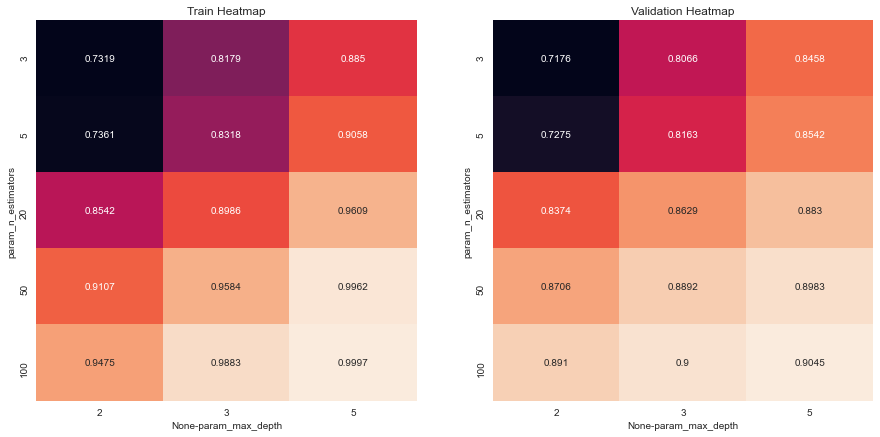

In [166]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[2,3,5], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[2,3,5], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- The parameters <i>max_depth==5 and n_estimators==20</i> seem to be the best values.

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


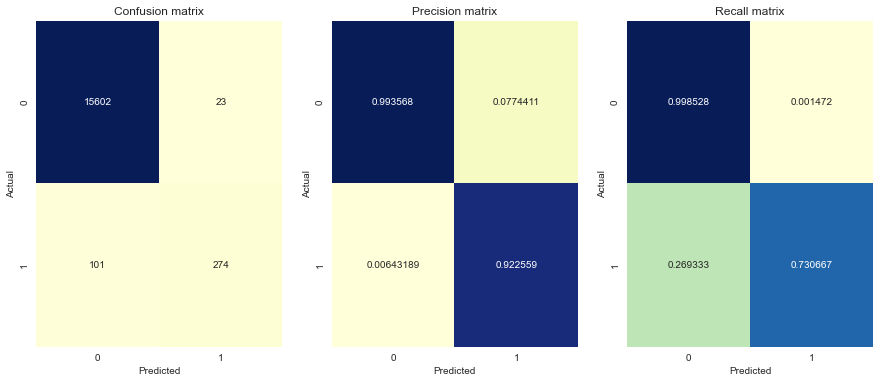

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9509030555556112
Test F-1 Score: 0.9057590349725182
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 79710
Test Misclassification cost: 50730
Train auc: 0.9971011779661015
Test auc: 0.9944767146666667


In [173]:
# training the best model
xgb = XGBClassifier(max_depth=5, n_estimators=20, n_jobs=-1)
xgb.fit(x_train, y_train)

# pexgbormance report
evaluate_performance(xgb, x_train, y_train, x_test, y_test)
# printing the auc scores
print_auc(xgb, x_train, y_train, x_test, y_test)

- In XGBoost too, the model performance has improved a little bit by using the anomaly features.
- The misclassification cost has decrease by a bit and the recall for positive class has improved a little.
- However, the f1 scores have remained almost same.

Now, lets tune and find the best threshold for prediction.

100%|████████████████████████████████████████████████████████████████████████████████| 645/645 [00:10<00:00, 59.29it/s]


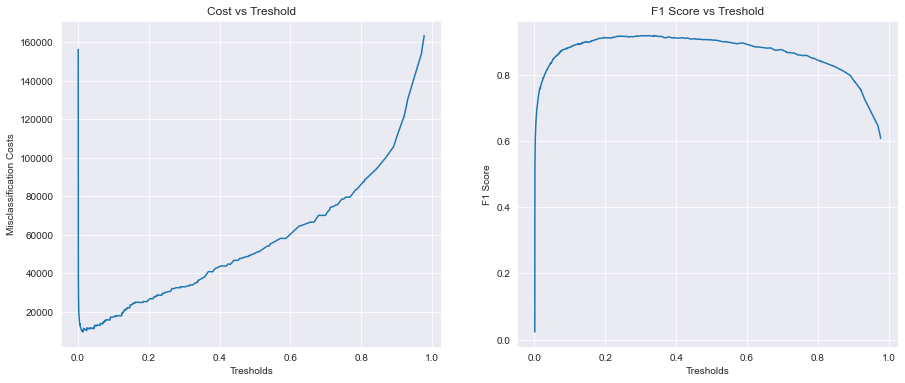

Minimum Cost: 9590
Maximum F1 Score: 0.9194482345384772


In [174]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = xgb.predict_proba(x_test)
tpr, fpr, tresh = roc_curve(y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The minimum cost is 9590 for threshold very close to 0.
- The maximum f1 score is 0.919 for a threshold in the range 0.2-0.4.
- We are going to select the value of threshold to be equal to 0.2.

#### Evaluating model using best threshold.

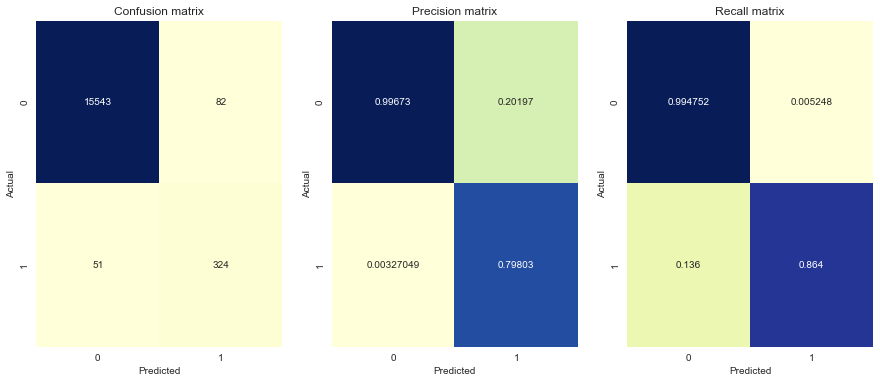

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 32990
Test Misclassification Costs: 26320
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9378258660603753
Test f-1 scores: 0.9127226398087542
----------------------------------------------------------------------------------------------------
Train AUC: 0.9673135593220339
Test AUC: 0.9293759999999999


In [180]:
# train preds
train_probs = xgb.predict_proba(x_train)[:,1]
test_probs = xgb.predict_proba(x_test)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.2, train_probs)
y_hat_test = treshold_predictions(0.2, test_probs)

# evaluate pexgbormance - print confusion matrix
plot_matrices(y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(y_train, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(y_train, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(y_train, y_hat_train))
print("Test AUC:", roc_auc_score(y_test, y_hat_test))

#### Observations:
- Initially, XGBoost had better score on the anomaly feature dataset with the default threshold.
- However, after tuning the threshold too, the performance becomes more or less equivalent.

### 4. XGBoost (With Encodings)

In [181]:
# model
xgb = XGBClassifier(n_jobs=-1)
# parameters
params = {'n_estimators':[3,5,20,50,100],
         'max_depth':[2,3,5]}

In [183]:
# random search
xgb_randomsearch = RandomizedSearchCV(xgb, param_distributions=params,
                                    n_jobs=-1, verbose=10, n_iter=15, scoring=scoring, return_train_score=True,
                                    refit='f1_macro', cv=3, random_state=24)
xgb_randomsearch.fit(x_train_enc, y_train)
print(xgb_randomsearch.best_params_)
print(xgb_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:19:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'n_estimators': 100, 'max_depth': 5}
0.9043905961640806


In [184]:
# getting the results
results = pd.DataFrame(xgb_randomsearch.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_train_f1_macro', 'mean_test_f1_macro', 'mean_train_roc_auc', 'mean_test_roc_auc']]
results

,param_n_estimators,param_max_depth,mean_train_f1_macro,mean_test_f1_macro,mean_train_roc_auc,mean_test_roc_auc
0,3,2,0.731898,0.717554,0.939281,0.935570
1,5,2,0.736073,0.727549,0.961956,0.952494
2,20,2,0.853296,0.834793,0.988669,0.984454
3,50,2,0.910557,0.871510,0.994089,0.987489
4,100,2,0.946642,0.881121,0.997199,0.989697
5,3,3,0.818476,0.806783,0.943602,0.939193
6,5,3,0.832958,0.814649,0.974791,0.960410
7,20,3,0.896716,0.861882,0.993755,0.985520
8,50,3,0.958089,0.889037,0.998028,0.988686
9,100,3,0.989360,0.898357,0.999807,0.990069


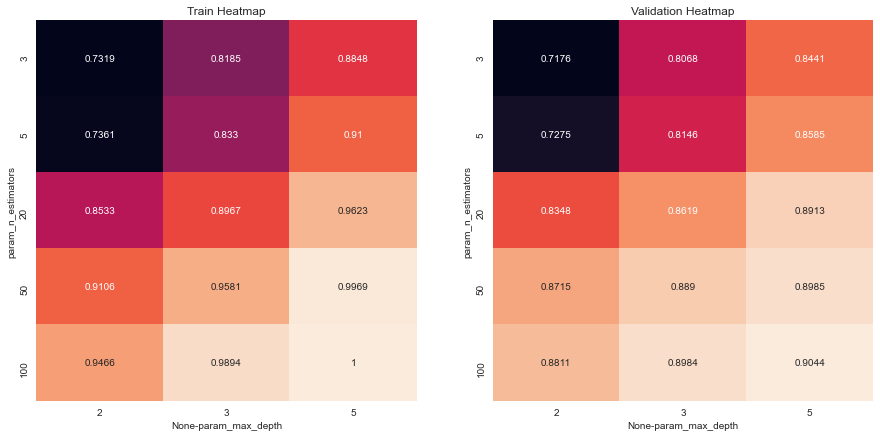

In [185]:
# lets plot the test f1-scores and roc-auc scores for each hyperparameters in a heatmap
# dropping the roc scores from the results
results = results.drop(columns=['mean_train_roc_auc', 'mean_test_roc_auc'])

# making a grid from the scores - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html
grid = results.pivot(columns='param_max_depth', index='param_n_estimators')

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
# train heatmap - https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_train_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[2,3,5], ax=ax[0], cbar=False, fmt='.4g')
ax[0].set_title('Train Heatmap')
# test heatmap
sc = grid.iloc[:, grid.columns.get_level_values(0)=='mean_test_f1_macro']
sns.heatmap(sc, annot=True, xticklabels=[2,3,5], ax=ax[1], cbar=False, fmt='.4g')
ax[1].set_title('Validation Heatmap')

plt.show()

- <i>max_depth==5 and n_estimators==20</i> seems to be the best values.

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


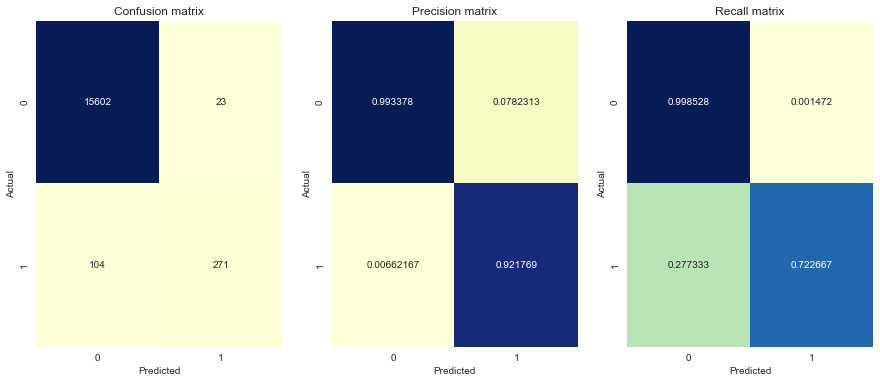

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9535298387962337
Test F-1 Score: 0.9030554655844756
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 75700
Test Misclassification cost: 52230
Train auc: 0.9966255
Test auc: 0.9941865813333333


In [186]:
# training the best model
xgb = XGBClassifier(max_depth=5, n_estimators=20, n_jobs=-1)
xgb.fit(x_train_enc, y_train)

# pexgbormance report
evaluate_performance(xgb, x_train_enc, y_train, x_test_enc, y_test)
# printing the auc scores
print_auc(xgb, x_train_enc, y_train, x_test_enc, y_test)

- Adding the encodings make the performance a little worse, the cost has increased just a little bit. 
- Overall the performance is same in this case as well.

#### Now, lets find the optimal threshold and observe the changes.

100%|████████████████████████████████████████████████████████████████████████████████| 636/636 [00:10<00:00, 58.25it/s]


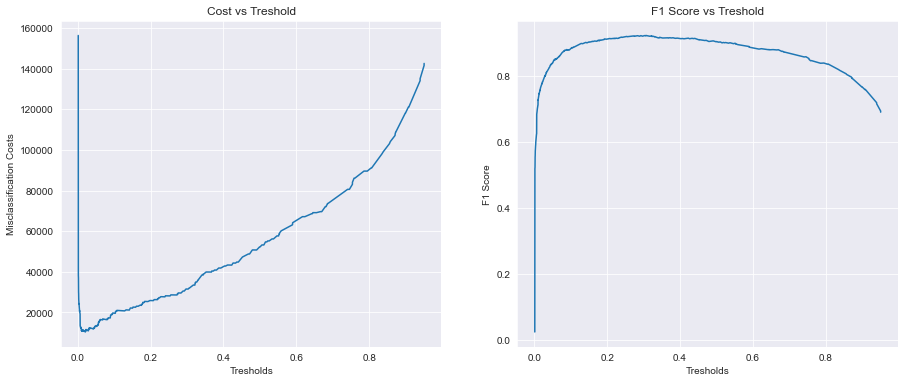

Minimum Cost: 10420
Maximum F1 Score: 0.9215306079889218


In [187]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = xgb.predict_proba(x_test_enc)
tpr, fpr, tresh = roc_curve(y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The minimum cost is 10420 at threshold close to 0.
- The maximum f1 score is 0.92 at threshold in the range 0.2 - 0.4
- We are going to select a threshold value of 0.15, since for that we have a f1 score around 0.9 and a cost of about 20,000.

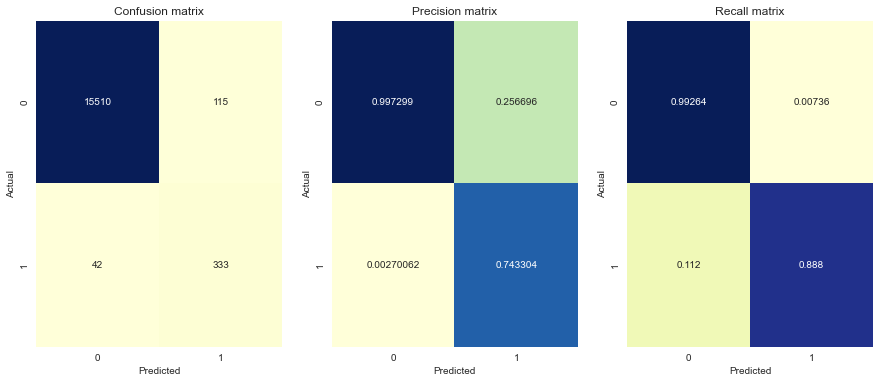

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 25270
Test Misclassification Costs: 22150
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.9171714491950042
Test f-1 scores: 0.9020993721771482
----------------------------------------------------------------------------------------------------
Train AUC: 0.975228813559322
Test AUC: 0.9403199999999999


In [189]:
# train preds
train_probs = xgb.predict_proba(x_train_enc)[:,1]
test_probs = xgb.predict_proba(x_test_enc)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.15, train_probs)
y_hat_test = treshold_predictions(0.15, test_probs)

# evaluate pexgbormance - print confusion matrix
plot_matrices(y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(y_train, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(y_train, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(y_train, y_hat_train))
print("Test AUC:", roc_auc_score(y_test, y_hat_test))

### Summarizing the performance of models on feature sets:

## Performance Review

In [207]:
# summarizing model performance
from prettytable import PrettyTable

x = PrettyTable(field_names=['Feature Set', 'Model', 'Threshold', 'Test F1-score', 'Test Misclassification Cost', 'Positive Class Recall', 'FN', 'FP'])
x.add_row(['Anomaly', 'RF', '0.5', '0.891', '58240', '0.69', '116', '24'])
x.add_row(['Anomaly', 'RF', '0.2', '0.90', '21220', '0.89', '40', '122'])
x.add_row(['Anomaly', 'XGBoost', '0.5', '0.905', '50730', '0.73', '101', '23'])
x.add_row(['Anomaly', 'XGBoost', '0.2', '0.912', '26320', '0.86', '51', '82'])
x.add_row(['Anomaly+Encoding', 'RF', '0.5', '0.897', '56690', '0.70', '113', '19'])
x.add_row(['Anomaly+Encoding', 'RF', '0.2', '0.89', '24690', '0.87', '47', '119'])
x.add_row(['Anomaly+Encoding', 'XGBoost', '0.5', '0.903', '52230', '0.72', '104', '23'])
x.add_row(['Anomaly+Encoding', 'XGBoost', '0.2', '0.902', '22150', '0.88', '42', '115'])

print(x)

+------------------+---------+-----------+---------------+-----------------------------+-----------------------+-----+-----+
|   Feature Set    |  Model  | Threshold | Test F1-score | Test Misclassification Cost | Positive Class Recall |  FN |  FP |
+------------------+---------+-----------+---------------+-----------------------------+-----------------------+-----+-----+
|     Anomaly      |    RF   |    0.5    |     0.891     |            58240            |          0.69         | 116 |  24 |
|     Anomaly      |    RF   |    0.2    |      0.90     |            21220            |          0.89         |  40 | 122 |
|     Anomaly      | XGBoost |    0.5    |     0.905     |            50730            |          0.73         | 101 |  23 |
|     Anomaly      | XGBoost |    0.2    |     0.912     |            26320            |          0.86         |  51 |  82 |
| Anomaly+Encoding |    RF   |    0.5    |     0.897     |            56690            |          0.70         | 113 |  19 |


A few observations about the feature engineering and hyperparameter tuning:-
- In general, keeping everything in mind, XGBoost is performing better than Random Forests.
- Introducing features, especially anomaly features, we are getting a little improvement in the model performance, especially for Random Forest in terms of misclassification cost. However, the f1 score remains same. Adding the encodings also has some improvement.
- For XGBoost, introducing anomaly features has very minor improvement in the cost and the recall for positive class. Adding encodings actually make the model perform worse.
- However, one thing to note is that the improvement is only for when we are using the default threshold and when we find the optimal value of the threshold, models start performing similar on both all the sets.
- For default threshold value of 0.5, the models had a slight tendency to overfit for the f1 score. However, this stops when we use the optimal threshold.
- ___IMPORTANT___ One thing to note about the threshold is that when we use the optimal value of threshold, which is less than 0.5 in all the cases, the precision of the positive class decreases proportionally. The reason for this is that by having a threshold less than 0.5, we are essentially adding a bias to the model for the positive class and due to this, we are going to make the model predict more and more datapoints to be positive and although this leads to an increase in the recall score, the precision takes a hit. This is the reason why the f1 score remains more or less same before and after using the optimal threshold values.
- ___IMPORTANT___ Also, the features that we constructed are not very useful in making predictions. Especially if we are using the tuned threshold values instead of the default 0.5.
- Thus, the overall best model we currently have is the __XGBoost model trained on the normal train data with a misclassification cost of 21310 and an f-1 score of 0.914 with a threshold of 0.15.__

# Using data balancing techniques for class imbalance.
Till now, for solving the problem of class imbalance, we were performing hyperparameter tuning and changing the models themselves to get low costs. Now, let us use techniques that change the dataset itself in order to combat the problem of class imbalance. For this, we are going to use the following techniques:-
1. SMOTEBoost -
<t> https://www.researchgate.net/publication/220698913_SMOTEBoost_Improving_Prediction_of_the_Minority_Class_in_Boosting 
2. RUSBoost - https://sci2s.ugr.es/keel/pdf/algorithm/articulo/2010-IEEE%20TSMCpartA-RUSBoost%20A%20Hybrid%20Approach%20to%20Alleviating%20Class%20Imbalance.pdf

refer [this](https://medium.com/urbint-engineering/using-smoteboost-and-rusboost-to-deal-with-class-imbalance-c18f8bf5b805) for python implementation of both of these models.

In [14]:
from rusboost import RUSBoost 
from smoteboost import SMOTEBoost

### 1.SMOTEBoost

SMOTEBoost is a custom boosting ensemble method that performs _SMOTE (Synthetic Minority Oversampling TEchnique)_ to deal with the class imbalance in the dataset. SMOTE is a complex technique that is used for performing oversampling of the majority class datapoints. It does this by _intelligently_ creating synthetic datapoints for minority class and hence balances the dataset. SMOTE creates synthetic datapoints on the lines that connect already existing minority class datapoints.
SMOTEBoost performs SMOTE before training of every base learner from scratch in order to create a balanced dataset for every base learner to train on. As a result, it treats the class imbalance in the dataset and improves model performance.

__Note:__ Since this is a custom implementation of the models and not provided by scikit learn, doing k-fold cv for this model using sklearn functions gives me an attribute error. Hence, for both SMOTEBoost and RUSBoost models, I am going to manually perform cv.

In [116]:
# hyperparameter tuning
# we are going to tune the parameters k_neighbours and n_estimators
# the params list will be in the form of [(n_estimators, k_neighbours)]
params = [(50,5), (50,7), (100,3) ,(100,5), (100,7), (200,5), (200,7)]

In [118]:
from numpy import random
# performing manual random search for smoteboost
train_f1 = []
cv_f1 = []
train_auc = []
cv_auc = []


# for splitting the data into train and validation
skf = StratifiedKFold(n_splits=3, shuffle=True)

# running this loop 10 times
for param in params:
    iter_f1_train = []
    iter_f1_test = []
    iter_auc_train = []
    iter_auc_test = []
    # getting the model parameters
    n_estimators = param[0]
    knn = param[1]
    print("---Parameters---")
    print(f'n_estimators: {n_estimators}\tk_neighbours: {knn}')
    # continue
    # declaring the model
    smote = SMOTEBoost(n_estimators=n_estimators, k_neighbors=knn)
    
    # 3 fold cv
    for (tr_ind, te_ind) in skf.split(knn_train, Y):
        # getting the data
        x_train = knn_train.iloc[tr_ind]
        y_train = Y[tr_ind]
        x_test = knn_train.iloc[te_ind]
        y_test  = Y[te_ind]
        # fitting the model
        smote.fit(x_train, y_train)
        # getting the predictions and performance metrics
        train_preds = smote.predict(x_train)
        test_preds = smote.predict(x_test)
        iter_f1_tr = f1_score(y_train, train_preds, average='macro')
        iter_f1_te = f1_score(y_test, test_preds, average='macro')
        iter_auc_tr = roc_auc_score(y_train, train_preds)
        iter_auc_te = roc_auc_score(y_test, test_preds)
        # appending to lists
        iter_f1_train.append(iter_f1_tr)
        iter_f1_test.append(iter_f1_te)
        iter_auc_train.append(iter_auc_tr)
        iter_auc_test.append(iter_auc_te)
    # calculating the averages
    train_f1.append(sum(iter_f1_train)/3)
    cv_f1.append(sum(iter_f1_test)/3)
    train_auc.append(sum(iter_auc_train)/3)
    cv_auc.append(sum(iter_auc_test)/3)
    print('---SCORES---')
    print(f'Train F1 score: {train_f1[-1]}\t Validation F1 Score: {cv_f1[-1]}')
    print(f'Train AUC: {train_auc[-1]}\t Validation AUC: {cv_auc[-1]}')
    print('*'*100)

---Parameters---
n_estimators: 50	k_neighbours: 5
---SCORES---
Train F1 score: 0.8657953290802819	 Validation F1 Score: 0.8559074800167648
Train AUC: 0.8560516515008615	 Validation AUC: 0.8449493615732853
****************************************************************************************************
---Parameters---
n_estimators: 50	k_neighbours: 7
---SCORES---
Train F1 score: 0.8675108772528116	 Validation F1 Score: 0.8493050784423662
Train AUC: 0.8607452099346121	 Validation AUC: 0.8398137786157244
****************************************************************************************************
---Parameters---
n_estimators: 100	k_neighbours: 3
---SCORES---
Train F1 score: 0.8955205283518687	 Validation F1 Score: 0.8603970915438094
Train AUC: 0.8935613946192563	 Validation AUC: 0.859201108779239
****************************************************************************************************
---Parameters---
n_estimators: 100	k_neighbours: 5
---SCORES---
Train F1 score: 0.

#### Obserations from tuning
- We have a high value for f1 score of more than 0.85 for all the parameters here.
- The model has not overfitted for any hyperparameter value here.
- The best parameter set seems to be <i>n_estimators==200 and k_neighbours==7</i>.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


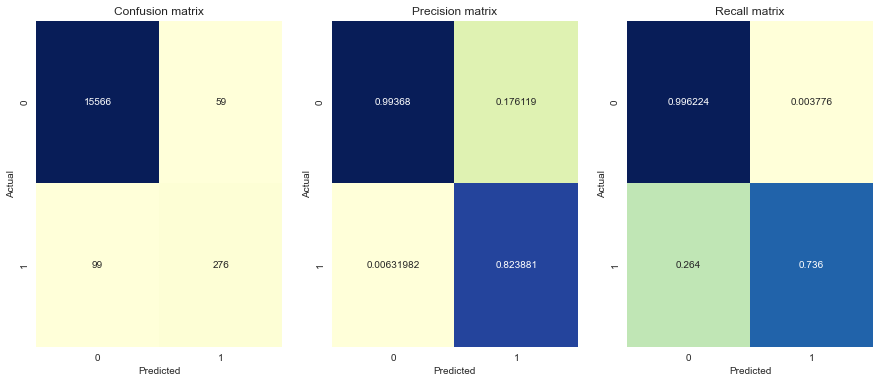

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9067998418041341
Test F-1 Score: 0.8862076260696169
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 99650
Test Misclassification cost: 50090
Train auc: 0.9976012966101695
Test auc: 0.9931933013333334


In [145]:
# training the best model
smote = SMOTEBoost(n_estimators=200, k_neighbors=7, random_state=42)
smote.fit(knn_train, Y)

# evaluating performance
evaluate_performance(smote, knn_train, Y, knn_test, Y_test)
print_auc(smote, knn_train, Y, knn_test, Y_test)

- SMOTEBoost model has better performance than the XGBoost with default threshold. It has a lower loss of 50090 but similar f1 score and higher recall for positive class.
- Now, let us see if changing the threshold improves the performance or not.

100%|██████████████████████████████████████████████████████████████████████████████| 2346/2346 [00:40<00:00, 57.99it/s]


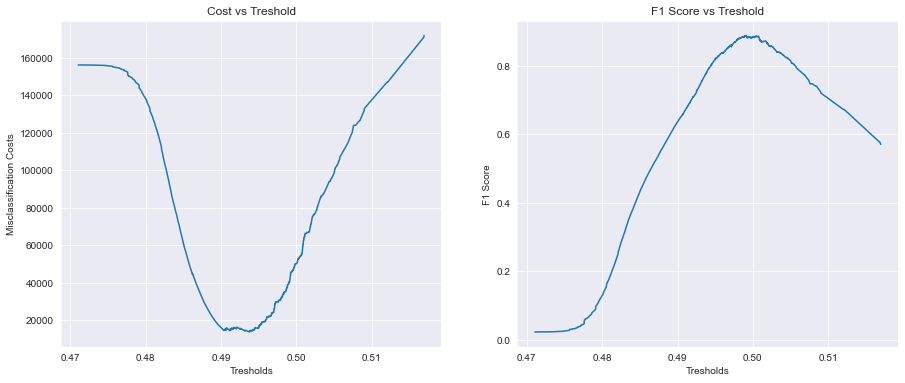

Minimum Cost: 13670
Maximum F1 Score: 0.8889098876296417


In [146]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = smote.predict_proba(knn_test)
tpr, fpr, tresh = roc_curve(Y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], Y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The lowest score is 13670 for a threshold between 0.49 and 0.5
- The highest f1 score is 0.88 for a value very close to 0.88 which is the already existing f1 score for the threshold of 0.5
- This means by decreasing the threshold by just a little we can get a very good improvement in the cost with a slight decrease in the f1 score. 
- Let us choose a threshold of 0.497 and see if we see any improvement.

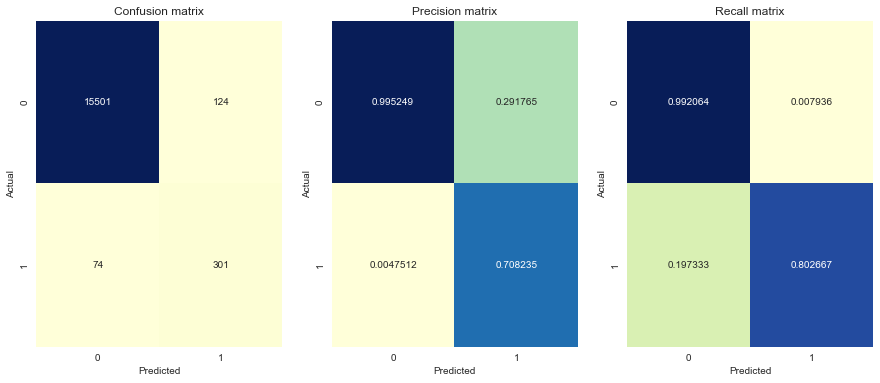

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 85750
Test Misclassification Costs: 38240
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.8675294554338673
Test f-1 scores: 0.8730769230769231
----------------------------------------------------------------------------------------------------
Train AUC: 0.9148983050847458
Test AUC: 0.8973653333333332


In [143]:
# train preds
train_probs = smote.predict_proba(knn_train)[:,1]
test_probs = smote.predict_proba(knn_test)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.497, train_probs)
y_hat_test = treshold_predictions(0.497, test_probs)

# evaluate pesmoteormance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(Y, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(Y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

### 2. RUSBoost
RUSBoost is a custom Boosting Ensemble method that performs Random UnderSampling (RUS) to tackle the case of class imbalance. RUS is an undersampling technique that randomly drops the datapoints that belong to the majority class. A problem with RUS is that it involves dropping of datapoints which ultimately leads to reduction of information available to the model for learning.

RUSBoost however, does not perform RUS on the dataset once and reduces the original dataset, instead, it perfoms RUS (with replacement) everytime a base learner is trained. This does not cause information loss as there is a very high chance that a datapoint dropped for one base learner will be seen by one or more learners in the future hence the overall information is kept conserved. As a result, generally RUSBoost has better performance on datasets than performing RUS and then modelling.

An advantage of RUSBoost over SMOTEBoost is that since we are dropping data instead of manufacturing data like in SMOTE, the process of training and prediction for RUSBoost models is much simpler and hence faster which makes it ideal for a low latency problem statement like in this case. 

Package Used:- https://github.com/dialnd/imbalanced-algorithms/blob/master/rus.py

In [87]:
# we are going to tune the parameters n_estimators, learning rate and min_ratio 
# the params will be of the following form - [(n_estimators, learning_rate, 'ratio')]
params = [(50,0.1,1.0), (100,0.1,0.3), (100,0.05,0.5), (100,0.1,1.0),
          (200,0.05,0.5), (200,0.1,0.3), (200,0.05,1.0),
          (500,0.1,0.3), (500,0.05,0.5)]

In [88]:
from numpy import random
# performing manual random search for rusboost
train_f1 = []
cv_f1 = []
train_auc = []
cv_auc = []


# for splitting the data into train and validation
skf = StratifiedKFold(n_splits=3, shuffle=True)

# running this loop 10 times
for param in params:
    iter_f1_train = []
    iter_f1_test = []
    iter_auc_train = []
    iter_auc_test = []
    print('Iteration:', i+1)
    # getting the model parameters
    n_estimators = param[0]
    lr = param[1]
    ratio = param[2]
    print("---Parameters---")
    print(f'n_estimators: {n_estimators}\tlearning_rate: {lr}\tmin_ratio: {ratio}')
    # continue
    # declaring the model
    rus = RUSBoost(n_estimators=n_estimators, random_state=0, learning_rate=lr, min_ratio=ratio)
    
    # 3 fold cv
    for (tr_ind, te_ind) in skf.split(knn_train, Y):
        # getting the data
        x_train = knn_train.iloc[tr_ind]
        y_train = Y[tr_ind]
        x_test = knn_train.iloc[te_ind]
        y_test  = Y[te_ind]
        # fitting the model
        rus.fit(x_train, y_train)
        # getting the predictions and performance metrics
        train_preds = rus.predict(x_train)
        test_preds = rus.predict(x_test)
        iter_f1_tr = f1_score(y_train, train_preds, average='macro')
        iter_f1_te = f1_score(y_test, test_preds, average='macro')
        iter_auc_tr = roc_auc_score(y_train, train_preds)
        iter_auc_te = roc_auc_score(y_test, test_preds)
        # appending to lists
        iter_f1_train.append(iter_f1_tr)
        iter_f1_test.append(iter_f1_te)
        iter_auc_train.append(iter_auc_tr)
        iter_auc_test.append(iter_auc_te)
    # calculating the averages
    train_f1.append(sum(iter_f1_train)/3)
    cv_f1.append(sum(iter_f1_test)/3)
    train_auc.append(sum(iter_auc_train)/3)
    cv_auc.append(sum(iter_auc_test)/3)
    print('---SCORES---')
    print(f'Train F1 score: {train_f1[-1]}\t Validation F1 Score: {cv_f1[-1]}')
    print(f'Train AUC: {train_auc[-1]}\t Validation AUC: {cv_auc[-1]}')
    print('*'*100)

Iteration: 5
---Parameters---
n_estimators: 50	learning_rate: 0.1	min_ratio: 1.0
---SCORES---
Train F1 score: 0.7932857563472706	 Validation F1 Score: 0.7923706061940093
Train AUC: 0.7760171073869767	 Validation AUC: 0.7767049023159801
****************************************************************************************************
Iteration: 5
---Parameters---
n_estimators: 100	learning_rate: 0.1	min_ratio: 0.3
---SCORES---
Train F1 score: 0.8275044604647867	 Validation F1 Score: 0.8141782619206176
Train AUC: 0.8660092749703469	 Validation AUC: 0.8466941138818335
****************************************************************************************************
Iteration: 5
---Parameters---
n_estimators: 100	learning_rate: 0.05	min_ratio: 0.5
---SCORES---
Train F1 score: 0.7960927904086557	 Validation F1 Score: 0.7894608939230622
Train AUC: 0.8458286876738556	 Validation AUC: 0.8365186094938779
***************************************************************************************

#### Observations from tuning:
- The current best performance comes from a model with 100 base estimators, a learning rate of 0.1 and min_ratio of 0.3
- The model hasnt overfit at all for any value of hyperparameters
- We can use higher n_estimators than 100 but should not go higher than 500 since the f1 score becomes bad which might mean that either the precision and recall for the positive class is decreased.

Let us use a model with n_estimators==200 and learning rate==0.1 and see the performance.

Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


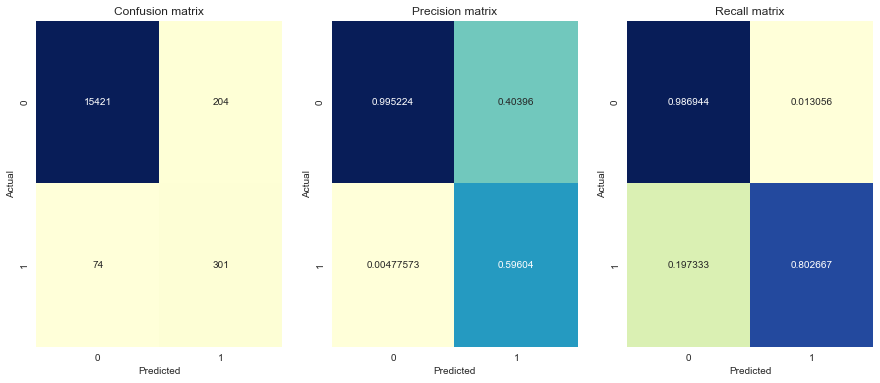

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.8062560016471416
Test F-1 Score: 0.8375788735685907
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 108250
Test Misclassification cost: 39040
Train auc: 0.9888440508474576
Test auc: 0.9901235199999999


In [141]:
# fitting the best model
rusa = RUSBoost(n_estimators=200, learning_rate=0.1, min_ratio=1.0)
rusa.fit(knn_train, Y)

# evaluating performance
evaluate_performance(rusa, knn_train, Y, knn_test, Y_test)
print_auc(rusa, knn_train, Y, knn_test, Y_test)

As we can see, the model has very low cost of 28270 for the default threshold only. It has a recall of 0.86 for the positive class. It is predicting a lot of points to belong to positive class now and hence making a lot of FP predictions as well and hence the precision for the positive class is very bad.
In order to solve this, let us tinker with the classification threshold and see if that changes anything. Going by the current trend in the cost vs threshold and the f1 score vs threshold plots, we could increase the threshold at the cost of increase in the misclassification cost to improve the f1 score and hence the precision of positive class.

100%|██████████████████████████████████████████████████████████████████████████████| 2813/2813 [00:48<00:00, 58.05it/s]


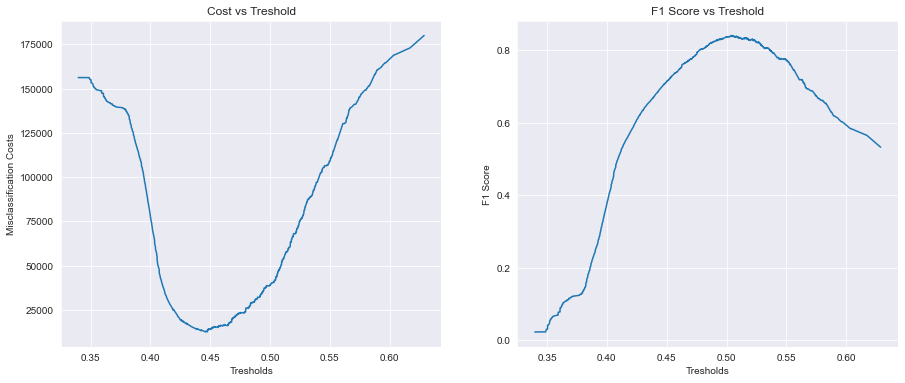

Minimum Cost: 12550
Maximum F1 Score: 0.8411951508578394


In [142]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = rusa.predict_proba(knn_test)
tpr, fpr, tresh = roc_curve(Y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], Y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

As we can see, the default threshold is pretty much the most optimal value. The f1 score here is very close to the maximum value but there is still scope of improvement of the cost. However, if we try to do that we are going to reduce the positive class precision a lot and that will not be ideal.

## Performance Review

In [151]:
from prettytable import PrettyTable

x = PrettyTable(field_names=['Model', 'Threshold', 'Test F1-score', 'Test Misclassification Cost', 'Positive Class Recall', 'FN', 'FP'])
x.add_row(['SMOTEBoost', '0.5', '0.88', '50990', '0.736', '99', '59'])
x.add_row(['SMOTEBoost', '0.497', '0.87', '38240', '0.802', '74', '124'])
x.add_row(['RUSBoost', '0.5', '0.83', '39040', '0.802', '74', '204'])

print(x)

+------------+-----------+---------------+-----------------------------+-----------------------+----+-----+
|   Model    | Threshold | Test F1-score | Test Misclassification Cost | Positive Class Recall | FN |  FP |
+------------+-----------+---------------+-----------------------------+-----------------------+----+-----+
| SMOTEBoost |    0.5    |      0.88     |            50990            |         0.736         | 99 |  59 |
| SMOTEBoost |   0.497   |      0.87     |            38240            |         0.802         | 74 | 124 |
|  RUSBoost  |    0.5    |      0.83     |            39040            |         0.802         | 74 | 204 |
+------------+-----------+---------------+-----------------------------+-----------------------+----+-----+


### Observations from the two algorithms
- Both the algorithms basically perform oversampling and undersampling respectively of the dataset.
- In doing so, they are trying to decrease the bias towards the negative class, or rather, increase the bias towards the positive class.
- The base models without tuned thresholds perform better than all the other models with default thresholds.
- However, the tuned thresholds of the other models outperform these two.
- Tuning the thresholds does note really do much for RUSBoost and SMOTEBoost as we saw that the ideal thresholds were very close to 0.5 and the optimal costs and f1 scores too were achieved very close to the thresholds of 0.5.
- The reason behind tuning thresholds not working is that the in earlier models, we were using thresholding as a tool to solve the problem of class imbalance. In RUS and SMOTEBoost models, this is done by under and oversampling respectively. Thus, this doesnt leave a lot of room to tune the thresholds in hopes to improve the performance as we saw in the plots.

# FINAL OBSERVATIONS
- The best model yet is __XGBoost we trained on the knn imputed dataset without any feature sets with a threshold of 0.15__.
- Features that we constructed do not improve the performance by a lot. They surely improved the performance by a fair amount in the models where we didnt use thresholding, but after thresholding we were able to get better results without them.
- Prediction threshold was the best parameter and tuning of it gave us the most improvement for all the models.
- The base models had bias towards negative class that lead to less number of points being predicted to the positive class. This was giving us a good precision score for the positive class but a poor recall.
- Thresholding and using data balancing techniques tried to reduce this bias and hence the models made more predictions of the positive class.
- This increased the positive class recall by a lot but decreased the precision score. This was a trade-off we had to make. Increasing the recall came at a cost of decerase in the precision.
- A model that increased the recall but had very low precision was considered bad. A model with low recall but high precision was also considered bad. However, recall being more important out of the two was allowed to be higher than the precision.
- This is the reason why the f1 scores remained similar for a model in all the kinds of tunings.
- Finally, the XGBoost model trained on the stock dataset with a threshold of 0.15 was the best model.

# RETRAINING THE BEST MODEL AND SAVING WITH THE BEST THRESHOLD.

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:54:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


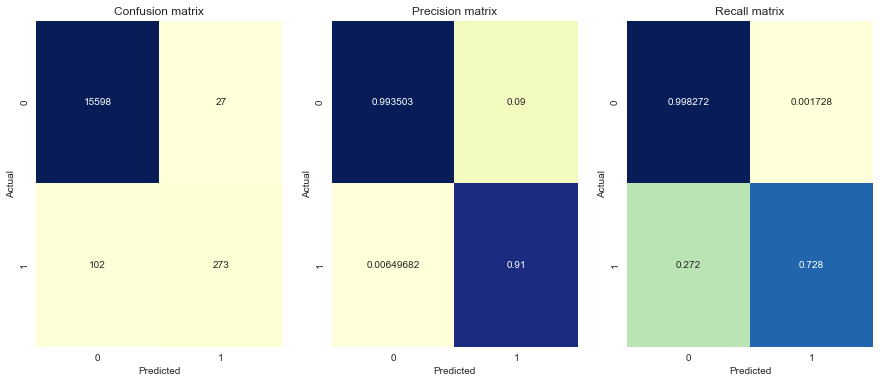

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9519876647256925
Test F-1 Score: 0.9023853861842689
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 81130
Test Misclassification cost: 51270
Train auc: 0.9959043644067797
Test auc: 0.9947892906666667


In [155]:
# FOR KNN
# training the best model
xgb = XGBClassifier(max_depth=5, n_estimators=20, n_jobs=-1)
xgb.fit(knn_train, Y)

# pexgbormance report
evaluate_performance(xgb, knn_train, Y, knn_test, Y_test)
# printing the auc scores
print_auc(xgb, knn_train, Y, knn_test, Y_test)

In [107]:
# Saving
best_models = {'model':xgb, 'threshold':0.17}
with open('Saves\\ML\\best_xgb_model_01.pkl', 'wb') as f:
    pickle.dump(best_models, f)

C:\Anaconda\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:59:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Making predictions...
---PERFORMANCE REPORT---
Confusion, Precision and Recall Matrices...


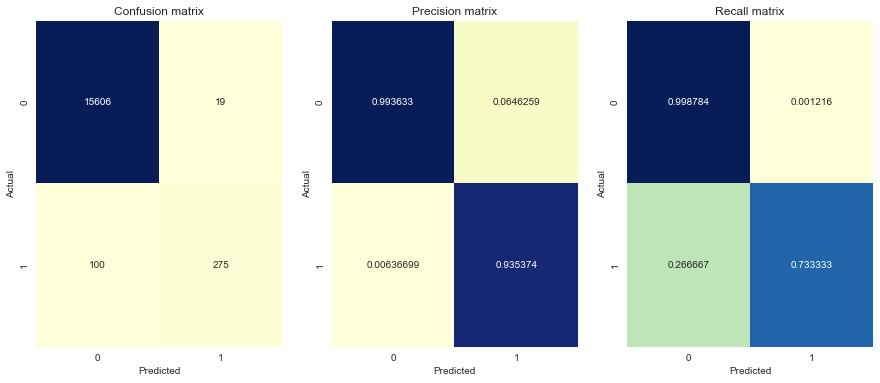

----------------------------------------------------------------------------------------------------
Train F-1 Score: 0.9619230804908407
Test F-1 Score: 0.9091622079098629
----------------------------------------------------------------------------------------------------
Train Misclassification cost: 65110
Test Misclassification cost: 50190
Train auc: 0.9986573474576271
Test auc: 0.9944910506666667


In [164]:
# FOR MICE
# training the best model
xgb = XGBClassifier(max_depth=5, n_estimators=25, n_jobs=-1)
xgb.fit(mice_train, Y)

# pexgbormance report
evaluate_performance(xgb, mice_train, Y, mice_test, Y_test)
# printing the auc scores
print_auc(xgb, mice_train, Y, mice_test, Y_test)

In [168]:
# Saving
best_models = {'model':xgb, 'threshold':0.15}
with open('Saves\\ML\\best_xgb_model_mice.pkl', 'wb') as f:
    pickle.dump(best_models, f)

# Further Improvements
- Some more extensive hyperparameter tuning of models and thresholds might yield better results.
- More feature Engineering can be explored.
- Earlier, some models were overfitting on the f1 score, doing threshold tuning on those might yield better results

# Making a Custom Stacking ensemble

Now, let us make a custom stacking ensemble model that will use a number of different models to and their predictions to make a final prediction. The Stacking classifier will be made in the following way:-
- Split the training data into 2 halves, say D1 and D2.
- Make k samples form D1 with replacement 
- Train k models on each of these k sample sets
- After training, make predictions on D2 from each of the k models, which will give us a prediction dataset of len(D2) * k shape
- On this dataset, train a meta classifier using the actual class labels.
- For evaluating the model performance, use the test sets and pass it to each of the k base classifiers and make perdicitons using the meta clasifier.
- The number of base models and the number of datapoints in each sample can be tuned as hypeparameters.

### 1. Split the train dataset into two halves

In [28]:
def split_train_data(data, labels):
    '''
        This function creates two datasets from the original dataset of equal length.
        Returns:- (x_d1, x_d2, y_d1, y_d2)
    '''
    X_d1, X_d2, Y_d1, Y_d2 = train_test_split(data, labels, stratify=labels)
    return (X_d1, X_d2, Y_d1, Y_d2)

### 2. Make samples from D1 with replacement.

In [29]:
def make_sample(data, labels, sample_proportion=0.6):
    '''
        This function makes samples of a fixed length from the dataset with replacement.
        NOTE: The labels should be a numpy array.
    '''
    # getting indices of the dataset for sampling
    sample_ind = np.random.choice(np.arange(len(data)), size=int(sample_proportion*len(data)), replace=True)
    
    # getting the data
    sample_x = data.iloc[sample_ind]
    sample_y = labels[sample_ind]
    
    return (sample_x, sample_y)

### 3. Making all the sample datasets.

In [30]:
def make_sample_sets(data, labels, k=5, sample_proportion=0.6):
    '''
        This function makes all the k sample sets and returns them in the form of a list where each element is a tuple of
        the format (datapoints, labels).
    '''
    k_samples = []
    for i in range(k):
        # get one sample
        sample = make_sample(data, labels, sample_proportion)
        # appending to the list
        k_samples.append(sample)
    return k_samples

### 4. Base learner
Each base learner would be XGBClassifiers choosen at random with optimal hyperparameters and will be trained on the given sample set.

In [31]:
def train_base_learner(data, labels):
    '''
        Each base learner XGBoost with optimal
        value of hyperparameters.
    '''
    
    # declare the model
    model = XGBClassifier(max_depth=3, n_estimators=50, n_jobs=-1)
    # fitting the model
    model.fit(data, labels)
    # return the model
    return model

### 5. Train all the models

In [32]:
def train_models(sample_sets):
    '''
        This function will train k base learners with each base learner being trained on a single sample set.
    '''
    trained_learners = [] # for storing all the trained base learners
    for k in range(len(sample_sets)):
        # get the labels and the sample set
        data = sample_sets[k][0]
        label = sample_sets[k][1]
        # train the base learner
        base_learner = train_base_learner(data, label)
        trained_learners.append(base_learner)
    return trained_learners

### 6. Make the prediction dataset and train a meta learner on it.
For meta learner, we are going to use a simple linear model such as a logistic regression model for final prediction.

In [33]:
def train_meta_learner(D2, labels, base_models):
    '''
        This function makes the meta dataset from the predicions of the base learners and train the meta classifier on that
        dataset. The meta classifier will be a logistic regression model.
    '''
    # making the dataset of predictions
    predictions = np.zeros((D2.shape[0], len(base_models)))
    
    # making prediction for each model and adding to dataset
    for i, model in enumerate(base_models):
        # predicting using model on D2
        preds = model.predict(D2)
        # adding the predictions
        predictions[:,i] = preds
        
    # declaring and training the meta classifier
    meta = SGDClassifier(loss='log')
    meta.fit(predictions, labels)
    
    return meta

### 7. The final stacking ensemble

In [34]:
def stacking_ensemble(data, labels, sample_proportion=0.6, k=5):
    '''
        This function implements the Stacking Ensemble model.
        Returns:
                (list of base models, meta-classifier)
    '''
    # make D1 and D2
    X_d1, X_d2, Y_d1, Y_d2 = split_train_data(data, labels)
    
    # make k samples
    samples = make_sample_sets(X_d1, Y_d1, k=k, sample_proportion=sample_proportion)
    
    # declaring and training all the base models
    base_models = train_models(samples)
    
    # make the dataset for meta classifier and train the meta classifier
    meta_learner = train_meta_learner(X_d2, Y_d2, base_models)
    
    return (base_models, meta_learner)

In [35]:
def stacking_predict(data, base_learners, meta_learner):
    '''
        This function performs predictions for the stacking ensemble classifier.
    '''
    # making predictions from base learners
    predictions = np.zeros((data.shape[0], len(base_learners)))
    for i,model in enumerate(base_learners):
        # getting the predictions
        preds = model.predict(data)
        predictions[:,i] = preds
    
    # finally predict using the meta_classsifier
    final_prediction = meta_learner.predict(predictions)
    return final_prediction

In [36]:
def stacking_predict_proba(data, base_learners, meta_learner):
    '''
        This function predicts the probability of a datapoint to belong to a class.
    '''
    # making predictions from base learners
    predictions = np.zeros((data.shape[0], len(base_learners)))
    for i, model in enumerate(base_learners):
        # getting the predictions
        preds = model.predict(data)
        predictions[:,i] = preds
        
    # getting the prediction probability
    probas = meta_learner.predict_proba(predictions)
    return probas

In [37]:
def gridsearch(X, Y, params, cv=3):
    '''
        This function performs gridsearch cv for the stacking ensemble model.
    '''
    n_models = params['k']
    ratio = params['sample_proportion']
    train_f1_score = []
    cv_f1_score = []
    train_auc = []
    cv_auc = []
    
    # K fold cv
    skf = StratifiedKFold(n_splits=cv)
    
    for k in n_models:
        for r in ratio:
            print('*'*100)
            print(f"---Number of base learners (k): {k}\tSampling Proportion: {r}---")
            f1_train_iter = []
            f1_cv_iter = []
            auc_train_iter = []
            auc_cv_iter = []
            
            # performing cv
            for tr_ind, te_ind in skf.split(X, Y):
                x_train, y_train = X.iloc[tr_ind], Y[tr_ind]
                x_test, y_test = X.iloc[te_ind], Y[te_ind]
                # fitting the model and making predictions
                base_models, meta_estimator = stacking_ensemble(x_train, y_train, r, k)
                # making predictions
                tr_pr = stacking_predict(x_train, base_models, meta_estimator)
                cv_pr = stacking_predict(x_test, base_models, meta_estimator)
                # calculating the metrics
                auc_tr = roc_auc_score(y_train, tr_pr)
                auc_te = roc_auc_score(y_test, cv_pr)
                f1_tr = f1_score(y_train, tr_pr, average='macro')
                f1_te = f1_score(y_test, cv_pr, average='macro')
                
                f1_train_iter.append(f1_tr)                
                f1_cv_iter.append(f1_te)
                auc_train_iter.append(auc_tr)
                auc_cv_iter.append(auc_te)
            
            train_f1_score.append(sum(f1_train_iter)/cv)
            cv_f1_score.append(sum(f1_cv_iter)/cv)
            train_auc.append(sum(auc_train_iter)/cv)
            cv_auc.append(sum(auc_cv_iter)/cv)
            
            print(f'Training AUC: {train_auc[-1]}\tValidation AUC; {cv_auc[-1]}')
            print(f'Training F-1 score: {train_f1_score[-1]}\tValidation F-1 score: {cv_f1_score[-1]}')
            
    return {'Training AUC':train_auc, 'CV AUC':cv_auc, 'Training F1 Score':train_f1_score, 'CV F1 Score':cv_f1_score}

In [318]:
# hyperparameter tuning the stacking classifier
params = {'k':[3,5,7,10], 'sample_proportion':[0.3,0.5,0.8]}
results = gridsearch(mice_train, Y, params)

****************************************************************************************************
---Number of base learners (k): 3	Sampling Proportion: 0.3---
Training AUC: 0.8464411971323931	Validation AUC; 0.7951297577577593
Training F-1 score: 0.892829173543685	Validation F-1 score: 0.8461540813939473
****************************************************************************************************
---Number of base learners (k): 3	Sampling Proportion: 0.5---
Training AUC: 0.8521308274922741	Validation AUC; 0.7988754549259621
Training F-1 score: 0.9007928406082236	Validation F-1 score: 0.8557934192036742
****************************************************************************************************
---Number of base learners (k): 3	Sampling Proportion: 0.8---
Training AUC: 0.8963801633751759	Validation AUC; 0.8211841566904797
Training F-1 score: 0.9309892465702844	Validation F-1 score: 0.8668120064459365
********************************************************************

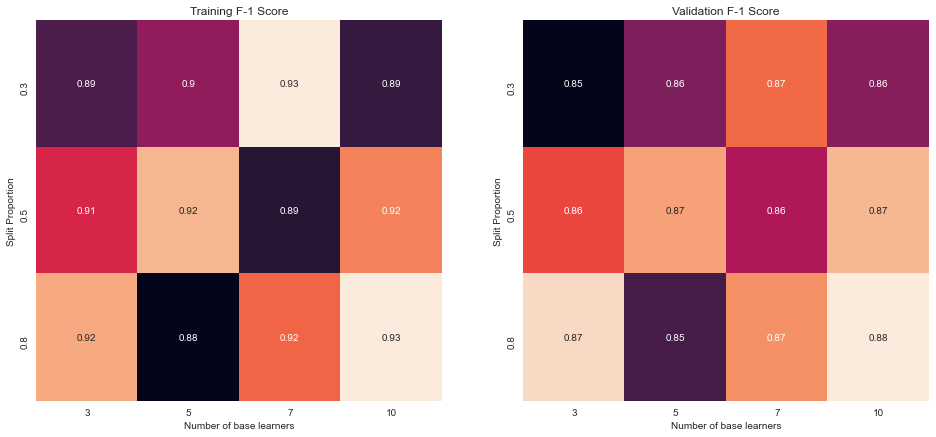

In [319]:
# plotting the confusion matrix
train_f1 = np.array(results['Training F1 Score']).reshape(3,4)
cv_f1 = np.array(results['CV F1 Score']).reshape(3,4)

# plotting the heatmap
fig, ax = plt.subplots(ncols=2, figsize=(16,7))
sns.heatmap(train_f1, annot=True, cbar=False, ax=ax[0])
ax[0].set_xticklabels([3,5,7,10])
ax[0].set_yticklabels([0.3,0.5,0.8])
ax[0].set_title("Training F-1 Score")
ax[0].set_xlabel('Number of base learners')
ax[0].set_ylabel('Split Proportion')

sns.heatmap(cv_f1, annot=True, cbar=False, ax=ax[1])
ax[1].set_xticklabels([3,5,7,10])
ax[1].set_yticklabels([0.3,0.5,0.8])
ax[1].set_title("Validation F-1 Score")
ax[1].set_xlabel('Number of base learners')
ax[1].set_ylabel('Split Proportion')

plt.show()

In [331]:
bl, ml = stacking_ensemble(mice_train, Y, 0.75, 10)

In [338]:
te_preds = stacking_predict(mice_test, bl, ml)
tr_preds = stacking_predict(mice_train, bl,ml)

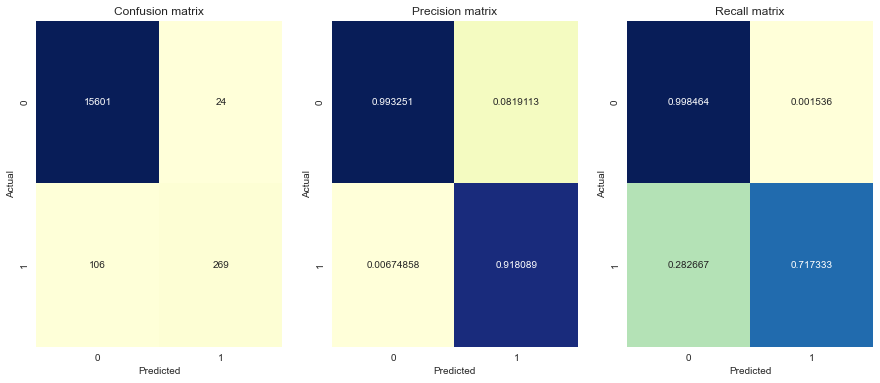

0.9006200544143426 0.929602114848551


In [339]:
plot_matrices(Y_test, te_preds)
print(f1_score(Y_test, te_preds, average='macro'), f1_score(Y, tr_preds, average='macro'))

In [340]:
misclassification_score(Y_test, te_preds), misclassification_score(Y, tr_preds)

(53240, 105930)

In [24]:
# saving or loading the ensemble
if not os.path.isfile('Saves\\ML\\stacking_ensemble.pkl'):
    print("Model isnt saved...saving")
    with open('Saves\\ML\\stacking_ensebmle.pkl', 'wb') as f:
        pickle.dump([bl,ml], f)
else:
    print("Model already present, loading...")
    with open('Saves\\ML\\stacking_ensemble.pkl', 'rb') as f:
        [bl, ml] = pickle.load(f)

Model already present, loading...


As we can see, the stacking ensemble performs very good and its performance is comparable to the random forest model.It has a higher f1 score of 0.90 and a misclassification score of 53240. Now, let us tune the prediction threshold for the meta classifier and see if that improves the model performance.

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:02<00:00, 61.57it/s]


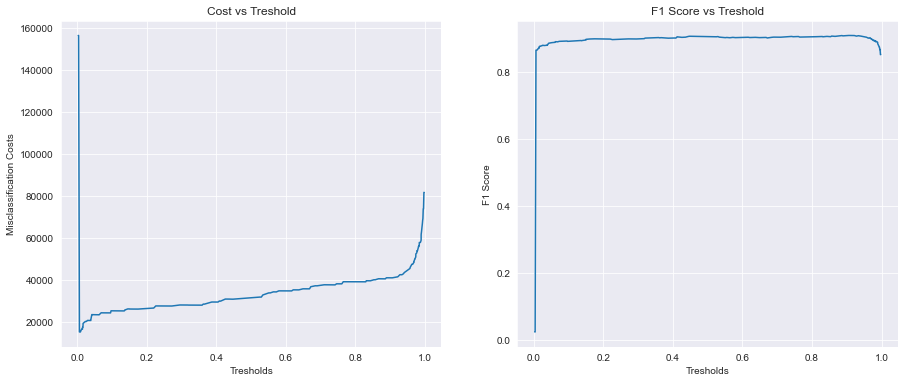

Minimum Cost: 15190
Maximum F1 Score: 0.9097510256419898


In [46]:
# plotting the roc auc curve for the test dataset with thresholds
# getting prediction scores 
probs = stacking_predict_proba(knn_test, bl, ml)
tpr, fpr, tresh = roc_curve(Y_test, probs[:,1])

# plotting the curve
costs, f1s = cost_vs_tresh(tresh[1:], probs[:,1], Y_test)
print("Minimum Cost:", min(costs))
print("Maximum F1 Score:", max(f1s))

- The least cost is 15190 at threshold very close to 0 which is larger compared to the other models.
- The maximum f1 score is 0.909 and is more or less constant throughout the threshold range.
- From the plot, we can see that even for the least misclassification error at threshold close to 0, the f1 score is pretty high. This might mean that the meta classifier has a bias towards the class 0 points given that th meta classifier we are using is a liner classifier.
- Thus, we can use a very small threshold for classification and expect to get good results.

For now, let us take 0.05 as the threshold for prediction.

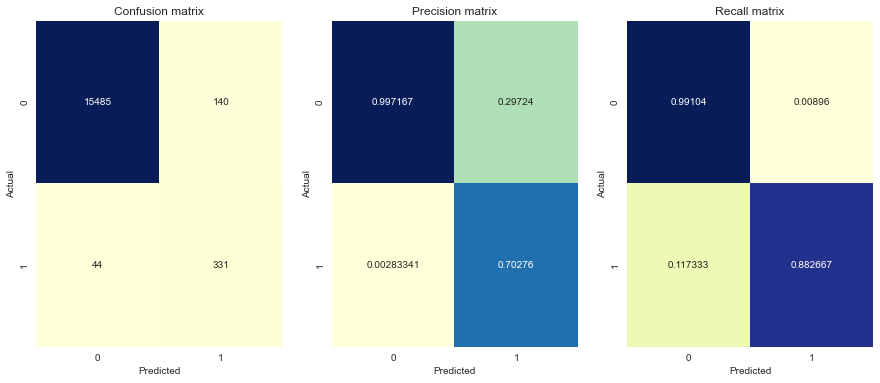

----------------------------------------------------------------------------------------------------
Train Misclassification Costs: 38820
Test Misclassification Costs: 23400
----------------------------------------------------------------------------------------------------
Train f-1 scores: 0.8918612577346586
Test f-1 scores: 0.88829988324606
----------------------------------------------------------------------------------------------------
Train AUC: 0.9618389830508475
Test AUC: 0.9368533333333334


In [50]:
# train preds
train_probs = stacking_predict_proba(knn_train, bl, ml)[:,1]
test_probs = stacking_predict_proba(knn_test, bl, ml)[:,1]

# use treshold to make predictions
y_hat_train = treshold_predictions(0.05, train_probs)
y_hat_test = treshold_predictions(0.05, test_probs)

# evaluate pexgbormance - print confusion matrix
plot_matrices(Y_test, y_hat_test)
# print miscalssification costs
print("-"*100)
print("Train Misclassification Costs:", misclassification_score(Y, y_hat_train))
print("Test Misclassification Costs:", misclassification_score(Y_test, y_hat_test))
print('-'*100)
# print f1 scores
print("Train f-1 scores:", f1_score(Y, y_hat_train, average='macro'))
print("Test f-1 scores:", f1_score(Y_test, y_hat_test, average='macro'))
print('-'*100)
# print AUC scores
print("Train AUC:", roc_auc_score(Y, y_hat_train))
print("Test AUC:", roc_auc_score(Y_test, y_hat_test))

We can see that using the stacking ensemble with a threshold equal to 0.05, we are getting misclassification score close to out best xgboost model. However, the precision of the stacking ensemble is worse than the xgboost model. However, it has the same recall score. 

__Further improvements on the stacking classifier__
- we can use different models instead of only one kind of model for different base learners
- Other more complex models as the meta classifier
- tuning the hyperparameters of the base and meta classifier.
- better tuning the staking model's hyperparameters.